In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (5000, 784), (10000, 784))

In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#         y -= l.sigmoid(0.0) # zero-centered/ mean
#         y *= 2.0 # uni-var/ std
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#             y -= l.sigmoid(0.0) # zero-centered/ mean
#             y *= 2.0 # uni-var/ std
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
#         dy =  dy @ self.W_fixed[2].T # done
        dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
#             dy =  dy @ self.W_fixed[2].T # done
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
        dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [4]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3219, acc-0.1200, valid loss-2.3191, acc-0.1034, test loss-2.3200, acc-0.0937
Iter-20, train loss-2.3418, acc-0.1000, valid loss-2.3190, acc-0.1040, test loss-2.3199, acc-0.0940
Iter-30, train loss-2.3174, acc-0.0600, valid loss-2.3188, acc-0.1044, test loss-2.3198, acc-0.0942
Iter-40, train loss-2.3151, acc-0.1800, valid loss-2.3187, acc-0.1046, test loss-2.3196, acc-0.0946
Iter-50, train loss-2.3148, acc-0.0800, valid loss-2.3185, acc-0.1046, test loss-2.3195, acc-0.0950
Iter-60, train loss-2.3034, acc-0.1400, valid loss-2.3184, acc-0.1052, test loss-2.3193, acc-0.0953
Iter-70, train loss-2.3074, acc-0.1200, valid loss-2.3183, acc-0.1052, test loss-2.3192, acc-0.0954
Iter-80, train loss-2.3214, acc-0.0800, valid loss-2.3181, acc-0.1056, test loss-2.3190, acc-0.0955
Iter-90, train loss-2.3169, acc-0.1200, valid loss-2.3180, acc-0.1058, test loss-2.3189, acc-0.0957
Iter-100, train loss-2.3270, acc-0.1200, valid loss-2.3178, acc-0.1058, test loss-2.3188, acc-0.0957

Iter-830, train loss-2.3097, acc-0.1000, valid loss-2.3076, acc-0.1178, test loss-2.3085, acc-0.1113
Iter-840, train loss-2.3053, acc-0.1400, valid loss-2.3075, acc-0.1184, test loss-2.3084, acc-0.1118
Iter-850, train loss-2.3083, acc-0.0600, valid loss-2.3073, acc-0.1184, test loss-2.3083, acc-0.1117
Iter-860, train loss-2.3190, acc-0.1000, valid loss-2.3072, acc-0.1188, test loss-2.3081, acc-0.1119
Iter-870, train loss-2.3070, acc-0.0800, valid loss-2.3071, acc-0.1190, test loss-2.3080, acc-0.1121
Iter-880, train loss-2.3010, acc-0.0800, valid loss-2.3069, acc-0.1188, test loss-2.3078, acc-0.1122
Iter-890, train loss-2.2944, acc-0.1000, valid loss-2.3068, acc-0.1192, test loss-2.3077, acc-0.1122
Iter-900, train loss-2.3009, acc-0.1600, valid loss-2.3066, acc-0.1196, test loss-2.3075, acc-0.1124
Iter-910, train loss-2.3344, acc-0.1000, valid loss-2.3065, acc-0.1202, test loss-2.3074, acc-0.1124
Iter-920, train loss-2.2926, acc-0.1200, valid loss-2.3063, acc-0.1200, test loss-2.3073, a

Iter-1640, train loss-2.3018, acc-0.1200, valid loss-2.2962, acc-0.1404, test loss-2.2972, acc-0.1326
Iter-1650, train loss-2.3215, acc-0.0400, valid loss-2.2961, acc-0.1406, test loss-2.2970, acc-0.1332
Iter-1660, train loss-2.2978, acc-0.1200, valid loss-2.2960, acc-0.1406, test loss-2.2969, acc-0.1330
Iter-1670, train loss-2.2979, acc-0.1400, valid loss-2.2958, acc-0.1408, test loss-2.2967, acc-0.1333
Iter-1680, train loss-2.2788, acc-0.1200, valid loss-2.2957, acc-0.1410, test loss-2.2966, acc-0.1334
Iter-1690, train loss-2.3103, acc-0.0800, valid loss-2.2955, acc-0.1412, test loss-2.2965, acc-0.1335
Iter-1700, train loss-2.2888, acc-0.1000, valid loss-2.2954, acc-0.1416, test loss-2.2963, acc-0.1338
Iter-1710, train loss-2.3112, acc-0.1000, valid loss-2.2953, acc-0.1414, test loss-2.2962, acc-0.1339
Iter-1720, train loss-2.2933, acc-0.1400, valid loss-2.2951, acc-0.1416, test loss-2.2960, acc-0.1346
Iter-1730, train loss-2.3068, acc-0.1000, valid loss-2.2950, acc-0.1422, test loss

Iter-2450, train loss-2.3015, acc-0.1000, valid loss-2.2852, acc-0.1582, test loss-2.2861, acc-0.1556
Iter-2460, train loss-2.2904, acc-0.1600, valid loss-2.2850, acc-0.1586, test loss-2.2860, acc-0.1559
Iter-2470, train loss-2.3017, acc-0.0600, valid loss-2.2849, acc-0.1590, test loss-2.2858, acc-0.1560
Iter-2480, train loss-2.3011, acc-0.1200, valid loss-2.2848, acc-0.1590, test loss-2.2857, acc-0.1565
Iter-2490, train loss-2.2801, acc-0.1600, valid loss-2.2846, acc-0.1594, test loss-2.2856, acc-0.1563
Iter-2500, train loss-2.2655, acc-0.1600, valid loss-2.2845, acc-0.1592, test loss-2.2854, acc-0.1568
Iter-2510, train loss-2.2815, acc-0.1800, valid loss-2.2844, acc-0.1600, test loss-2.2853, acc-0.1574
Iter-2520, train loss-2.2906, acc-0.1400, valid loss-2.2842, acc-0.1602, test loss-2.2852, acc-0.1573
Iter-2530, train loss-2.3126, acc-0.1000, valid loss-2.2841, acc-0.1612, test loss-2.2850, acc-0.1576
Iter-2540, train loss-2.2872, acc-0.2000, valid loss-2.2840, acc-0.1616, test loss

Iter-3260, train loss-2.2675, acc-0.1800, valid loss-2.2744, acc-0.1844, test loss-2.2753, acc-0.1822
Iter-3270, train loss-2.2804, acc-0.1800, valid loss-2.2743, acc-0.1846, test loss-2.2752, acc-0.1823
Iter-3280, train loss-2.2719, acc-0.1600, valid loss-2.2742, acc-0.1846, test loss-2.2750, acc-0.1827
Iter-3290, train loss-2.2569, acc-0.1800, valid loss-2.2740, acc-0.1850, test loss-2.2749, acc-0.1832
Iter-3300, train loss-2.2748, acc-0.1800, valid loss-2.2739, acc-0.1854, test loss-2.2748, acc-0.1836
Iter-3310, train loss-2.2696, acc-0.1600, valid loss-2.2738, acc-0.1852, test loss-2.2747, acc-0.1840
Iter-3320, train loss-2.2671, acc-0.1600, valid loss-2.2737, acc-0.1858, test loss-2.2745, acc-0.1839
Iter-3330, train loss-2.2549, acc-0.2000, valid loss-2.2735, acc-0.1860, test loss-2.2744, acc-0.1844
Iter-3340, train loss-2.2644, acc-0.2200, valid loss-2.2734, acc-0.1862, test loss-2.2742, acc-0.1848
Iter-3350, train loss-2.2793, acc-0.1800, valid loss-2.2733, acc-0.1864, test loss

Iter-4070, train loss-2.2342, acc-0.3400, valid loss-2.2637, acc-0.2106, test loss-2.2646, acc-0.2085
Iter-4080, train loss-2.2435, acc-0.3600, valid loss-2.2636, acc-0.2112, test loss-2.2645, acc-0.2087
Iter-4090, train loss-2.2806, acc-0.1800, valid loss-2.2635, acc-0.2114, test loss-2.2644, acc-0.2089
Iter-4100, train loss-2.2670, acc-0.2000, valid loss-2.2634, acc-0.2118, test loss-2.2643, acc-0.2092
Iter-4110, train loss-2.2644, acc-0.2200, valid loss-2.2632, acc-0.2118, test loss-2.2641, acc-0.2099
Iter-4120, train loss-2.2813, acc-0.1800, valid loss-2.2631, acc-0.2124, test loss-2.2640, acc-0.2099
Iter-4130, train loss-2.2534, acc-0.2800, valid loss-2.2629, acc-0.2126, test loss-2.2639, acc-0.2104
Iter-4140, train loss-2.2799, acc-0.2000, valid loss-2.2628, acc-0.2132, test loss-2.2637, acc-0.2107
Iter-4150, train loss-2.2640, acc-0.2000, valid loss-2.2627, acc-0.2136, test loss-2.2636, acc-0.2107
Iter-4160, train loss-2.2603, acc-0.2400, valid loss-2.2626, acc-0.2134, test loss

Iter-4880, train loss-2.2636, acc-0.2400, valid loss-2.2532, acc-0.2402, test loss-2.2541, acc-0.2357
Iter-4890, train loss-2.2576, acc-0.2400, valid loss-2.2531, acc-0.2408, test loss-2.2540, acc-0.2360
Iter-4900, train loss-2.2548, acc-0.2800, valid loss-2.2529, acc-0.2412, test loss-2.2538, acc-0.2363
Iter-4910, train loss-2.2583, acc-0.2400, valid loss-2.2528, acc-0.2416, test loss-2.2537, acc-0.2367
Iter-4920, train loss-2.2528, acc-0.2000, valid loss-2.2527, acc-0.2422, test loss-2.2536, acc-0.2369
Iter-4930, train loss-2.2629, acc-0.2400, valid loss-2.2525, acc-0.2426, test loss-2.2535, acc-0.2375
Iter-4940, train loss-2.2525, acc-0.2200, valid loss-2.2524, acc-0.2428, test loss-2.2533, acc-0.2377
Iter-4950, train loss-2.2339, acc-0.3400, valid loss-2.2523, acc-0.2428, test loss-2.2532, acc-0.2381
Iter-4960, train loss-2.2802, acc-0.1400, valid loss-2.2522, acc-0.2426, test loss-2.2531, acc-0.2388
Iter-4970, train loss-2.2607, acc-0.2800, valid loss-2.2520, acc-0.2432, test loss

Iter-5690, train loss-2.2338, acc-0.2400, valid loss-2.2429, acc-0.2684, test loss-2.2438, acc-0.2678
Iter-5700, train loss-2.2148, acc-0.3600, valid loss-2.2428, acc-0.2680, test loss-2.2437, acc-0.2682
Iter-5710, train loss-2.2642, acc-0.2200, valid loss-2.2427, acc-0.2682, test loss-2.2436, acc-0.2688
Iter-5720, train loss-2.2555, acc-0.2800, valid loss-2.2425, acc-0.2684, test loss-2.2435, acc-0.2690
Iter-5730, train loss-2.2203, acc-0.2800, valid loss-2.2424, acc-0.2686, test loss-2.2433, acc-0.2691
Iter-5740, train loss-2.2257, acc-0.2400, valid loss-2.2423, acc-0.2694, test loss-2.2432, acc-0.2694
Iter-5750, train loss-2.2258, acc-0.2800, valid loss-2.2421, acc-0.2696, test loss-2.2431, acc-0.2697
Iter-5760, train loss-2.2047, acc-0.3200, valid loss-2.2420, acc-0.2698, test loss-2.2430, acc-0.2699
Iter-5770, train loss-2.2494, acc-0.2000, valid loss-2.2419, acc-0.2704, test loss-2.2428, acc-0.2702
Iter-5780, train loss-2.2185, acc-0.3400, valid loss-2.2417, acc-0.2708, test loss

Iter-6500, train loss-2.2002, acc-0.3000, valid loss-2.2327, acc-0.2930, test loss-2.2336, acc-0.2934
Iter-6510, train loss-2.2405, acc-0.2400, valid loss-2.2326, acc-0.2928, test loss-2.2335, acc-0.2932
Iter-6520, train loss-2.2507, acc-0.2600, valid loss-2.2324, acc-0.2934, test loss-2.2334, acc-0.2936
Iter-6530, train loss-2.2163, acc-0.4200, valid loss-2.2323, acc-0.2942, test loss-2.2332, acc-0.2941
Iter-6540, train loss-2.2208, acc-0.3000, valid loss-2.2322, acc-0.2942, test loss-2.2331, acc-0.2941
Iter-6550, train loss-2.2425, acc-0.2800, valid loss-2.2321, acc-0.2944, test loss-2.2330, acc-0.2945
Iter-6560, train loss-2.2458, acc-0.2600, valid loss-2.2319, acc-0.2952, test loss-2.2329, acc-0.2948
Iter-6570, train loss-2.2425, acc-0.2200, valid loss-2.2318, acc-0.2954, test loss-2.2327, acc-0.2951
Iter-6580, train loss-2.2550, acc-0.2400, valid loss-2.2317, acc-0.2956, test loss-2.2326, acc-0.2956
Iter-6590, train loss-2.2406, acc-0.2600, valid loss-2.2316, acc-0.2964, test loss

Iter-7310, train loss-2.2216, acc-0.4000, valid loss-2.2227, acc-0.3146, test loss-2.2236, acc-0.3144
Iter-7320, train loss-2.2427, acc-0.2600, valid loss-2.2225, acc-0.3154, test loss-2.2235, acc-0.3148
Iter-7330, train loss-2.1985, acc-0.4000, valid loss-2.2224, acc-0.3158, test loss-2.2233, acc-0.3145
Iter-7340, train loss-2.2038, acc-0.3200, valid loss-2.2223, acc-0.3162, test loss-2.2232, acc-0.3146
Iter-7350, train loss-2.2346, acc-0.3200, valid loss-2.2222, acc-0.3166, test loss-2.2231, acc-0.3149
Iter-7360, train loss-2.2160, acc-0.3000, valid loss-2.2220, acc-0.3168, test loss-2.2230, acc-0.3153
Iter-7370, train loss-2.1969, acc-0.4000, valid loss-2.2219, acc-0.3168, test loss-2.2228, acc-0.3153
Iter-7380, train loss-2.1931, acc-0.3200, valid loss-2.2218, acc-0.3176, test loss-2.2227, acc-0.3157
Iter-7390, train loss-2.2455, acc-0.2800, valid loss-2.2217, acc-0.3178, test loss-2.2226, acc-0.3158
Iter-7400, train loss-2.1994, acc-0.5000, valid loss-2.2215, acc-0.3178, test loss

Iter-8120, train loss-2.2278, acc-0.2800, valid loss-2.2129, acc-0.3340, test loss-2.2138, acc-0.3308
Iter-8130, train loss-2.2391, acc-0.2600, valid loss-2.2128, acc-0.3342, test loss-2.2137, acc-0.3308
Iter-8140, train loss-2.2135, acc-0.3200, valid loss-2.2126, acc-0.3352, test loss-2.2136, acc-0.3311
Iter-8150, train loss-2.1765, acc-0.5200, valid loss-2.2125, acc-0.3352, test loss-2.2135, acc-0.3310
Iter-8160, train loss-2.2272, acc-0.2000, valid loss-2.2124, acc-0.3354, test loss-2.2134, acc-0.3313
Iter-8170, train loss-2.2061, acc-0.3000, valid loss-2.2123, acc-0.3356, test loss-2.2132, acc-0.3317
Iter-8180, train loss-2.2157, acc-0.3000, valid loss-2.2122, acc-0.3356, test loss-2.2131, acc-0.3320
Iter-8190, train loss-2.2364, acc-0.2800, valid loss-2.2121, acc-0.3358, test loss-2.2130, acc-0.3321
Iter-8200, train loss-2.1748, acc-0.4600, valid loss-2.2119, acc-0.3362, test loss-2.2129, acc-0.3323
Iter-8210, train loss-2.2327, acc-0.2800, valid loss-2.2118, acc-0.3364, test loss

Iter-8930, train loss-2.1932, acc-0.3200, valid loss-2.2033, acc-0.3480, test loss-2.2042, acc-0.3446
Iter-8940, train loss-2.2222, acc-0.3000, valid loss-2.2032, acc-0.3478, test loss-2.2041, acc-0.3446
Iter-8950, train loss-2.2084, acc-0.3000, valid loss-2.2030, acc-0.3482, test loss-2.2040, acc-0.3449
Iter-8960, train loss-2.2306, acc-0.3000, valid loss-2.2029, acc-0.3486, test loss-2.2038, acc-0.3448
Iter-8970, train loss-2.1982, acc-0.3200, valid loss-2.2028, acc-0.3494, test loss-2.2037, acc-0.3448
Iter-8980, train loss-2.2020, acc-0.3800, valid loss-2.2027, acc-0.3494, test loss-2.2036, acc-0.3449
Iter-8990, train loss-2.2260, acc-0.3000, valid loss-2.2025, acc-0.3486, test loss-2.2035, acc-0.3452
Iter-9000, train loss-2.2172, acc-0.3600, valid loss-2.2024, acc-0.3492, test loss-2.2033, acc-0.3451
Iter-9010, train loss-2.2239, acc-0.3000, valid loss-2.2023, acc-0.3496, test loss-2.2032, acc-0.3452
Iter-9020, train loss-2.2264, acc-0.3400, valid loss-2.2022, acc-0.3498, test loss

Iter-9740, train loss-2.2040, acc-0.3800, valid loss-2.1937, acc-0.3578, test loss-2.1945, acc-0.3544
Iter-9750, train loss-2.2096, acc-0.3000, valid loss-2.1935, acc-0.3576, test loss-2.1944, acc-0.3546
Iter-9760, train loss-2.2235, acc-0.2400, valid loss-2.1934, acc-0.3580, test loss-2.1943, acc-0.3549
Iter-9770, train loss-2.1967, acc-0.3000, valid loss-2.1933, acc-0.3586, test loss-2.1942, acc-0.3551
Iter-9780, train loss-2.1863, acc-0.3800, valid loss-2.1932, acc-0.3582, test loss-2.1941, acc-0.3552
Iter-9790, train loss-2.1417, acc-0.4600, valid loss-2.1931, acc-0.3582, test loss-2.1940, acc-0.3553
Iter-9800, train loss-2.1942, acc-0.3200, valid loss-2.1930, acc-0.3584, test loss-2.1938, acc-0.3554
Iter-9810, train loss-2.2157, acc-0.3000, valid loss-2.1928, acc-0.3582, test loss-2.1937, acc-0.3557
Iter-9820, train loss-2.1677, acc-0.4200, valid loss-2.1927, acc-0.3578, test loss-2.1936, acc-0.3560
Iter-9830, train loss-2.1983, acc-0.3400, valid loss-2.1926, acc-0.3568, test loss

Iter-10540, train loss-2.1539, acc-0.4400, valid loss-2.1843, acc-0.3652, test loss-2.1852, acc-0.3618
Iter-10550, train loss-2.1786, acc-0.3400, valid loss-2.1842, acc-0.3650, test loss-2.1851, acc-0.3617
Iter-10560, train loss-2.2167, acc-0.2600, valid loss-2.1841, acc-0.3646, test loss-2.1850, acc-0.3616
Iter-10570, train loss-2.1847, acc-0.3400, valid loss-2.1839, acc-0.3650, test loss-2.1849, acc-0.3621
Iter-10580, train loss-2.1894, acc-0.3400, valid loss-2.1838, acc-0.3646, test loss-2.1847, acc-0.3620
Iter-10590, train loss-2.2092, acc-0.3000, valid loss-2.1837, acc-0.3650, test loss-2.1846, acc-0.3623
Iter-10600, train loss-2.1453, acc-0.4000, valid loss-2.1836, acc-0.3648, test loss-2.1845, acc-0.3622
Iter-10610, train loss-2.1708, acc-0.4400, valid loss-2.1835, acc-0.3650, test loss-2.1844, acc-0.3625
Iter-10620, train loss-2.1884, acc-0.3400, valid loss-2.1834, acc-0.3656, test loss-2.1843, acc-0.3625
Iter-10630, train loss-2.1809, acc-0.4000, valid loss-2.1832, acc-0.3658,

Iter-11340, train loss-2.2087, acc-0.3000, valid loss-2.1752, acc-0.3688, test loss-2.1761, acc-0.3679
Iter-11350, train loss-2.1872, acc-0.3200, valid loss-2.1751, acc-0.3688, test loss-2.1760, acc-0.3676
Iter-11360, train loss-2.1654, acc-0.3200, valid loss-2.1750, acc-0.3692, test loss-2.1758, acc-0.3678
Iter-11370, train loss-2.1674, acc-0.3600, valid loss-2.1748, acc-0.3686, test loss-2.1757, acc-0.3677
Iter-11380, train loss-2.1914, acc-0.3200, valid loss-2.1747, acc-0.3688, test loss-2.1756, acc-0.3677
Iter-11390, train loss-2.1718, acc-0.4000, valid loss-2.1746, acc-0.3688, test loss-2.1755, acc-0.3673
Iter-11400, train loss-2.2104, acc-0.3400, valid loss-2.1745, acc-0.3690, test loss-2.1754, acc-0.3674
Iter-11410, train loss-2.1724, acc-0.3800, valid loss-2.1744, acc-0.3692, test loss-2.1753, acc-0.3673
Iter-11420, train loss-2.1604, acc-0.4000, valid loss-2.1743, acc-0.3692, test loss-2.1751, acc-0.3672
Iter-11430, train loss-2.1446, acc-0.4000, valid loss-2.1742, acc-0.3694,

Iter-12140, train loss-2.1517, acc-0.4400, valid loss-2.1662, acc-0.3754, test loss-2.1671, acc-0.3729
Iter-12150, train loss-2.1487, acc-0.4000, valid loss-2.1661, acc-0.3758, test loss-2.1670, acc-0.3732
Iter-12160, train loss-2.1589, acc-0.4000, valid loss-2.1660, acc-0.3760, test loss-2.1668, acc-0.3729
Iter-12170, train loss-2.1802, acc-0.3800, valid loss-2.1659, acc-0.3760, test loss-2.1667, acc-0.3728
Iter-12180, train loss-2.2041, acc-0.2800, valid loss-2.1658, acc-0.3760, test loss-2.1666, acc-0.3729
Iter-12190, train loss-2.1759, acc-0.4200, valid loss-2.1657, acc-0.3758, test loss-2.1665, acc-0.3733
Iter-12200, train loss-2.1792, acc-0.4200, valid loss-2.1656, acc-0.3760, test loss-2.1664, acc-0.3732
Iter-12210, train loss-2.1193, acc-0.4400, valid loss-2.1654, acc-0.3760, test loss-2.1663, acc-0.3732
Iter-12220, train loss-2.1619, acc-0.3600, valid loss-2.1653, acc-0.3760, test loss-2.1662, acc-0.3732
Iter-12230, train loss-2.1671, acc-0.3800, valid loss-2.1652, acc-0.3766,

Iter-12940, train loss-2.1657, acc-0.4400, valid loss-2.1573, acc-0.3812, test loss-2.1581, acc-0.3776
Iter-12950, train loss-2.1514, acc-0.3400, valid loss-2.1572, acc-0.3812, test loss-2.1580, acc-0.3778
Iter-12960, train loss-2.1384, acc-0.4000, valid loss-2.1570, acc-0.3806, test loss-2.1579, acc-0.3779
Iter-12970, train loss-2.1668, acc-0.3600, valid loss-2.1569, acc-0.3806, test loss-2.1578, acc-0.3780
Iter-12980, train loss-2.1416, acc-0.3800, valid loss-2.1568, acc-0.3812, test loss-2.1577, acc-0.3778
Iter-12990, train loss-2.1515, acc-0.3400, valid loss-2.1567, acc-0.3808, test loss-2.1576, acc-0.3779
Iter-13000, train loss-2.1502, acc-0.4600, valid loss-2.1566, acc-0.3812, test loss-2.1575, acc-0.3779
Iter-13010, train loss-2.1722, acc-0.2800, valid loss-2.1565, acc-0.3814, test loss-2.1574, acc-0.3778
Iter-13020, train loss-2.1496, acc-0.3600, valid loss-2.1564, acc-0.3814, test loss-2.1572, acc-0.3780
Iter-13030, train loss-2.1560, acc-0.3400, valid loss-2.1563, acc-0.3814,

Iter-13740, train loss-2.1368, acc-0.4600, valid loss-2.1486, acc-0.3884, test loss-2.1494, acc-0.3820
Iter-13750, train loss-2.1518, acc-0.4200, valid loss-2.1485, acc-0.3884, test loss-2.1493, acc-0.3820
Iter-13760, train loss-2.1894, acc-0.2400, valid loss-2.1484, acc-0.3882, test loss-2.1492, acc-0.3822
Iter-13770, train loss-2.1396, acc-0.3600, valid loss-2.1483, acc-0.3882, test loss-2.1491, acc-0.3823
Iter-13780, train loss-2.1454, acc-0.3800, valid loss-2.1482, acc-0.3880, test loss-2.1490, acc-0.3825
Iter-13790, train loss-2.1180, acc-0.4600, valid loss-2.1481, acc-0.3880, test loss-2.1489, acc-0.3823
Iter-13800, train loss-2.1487, acc-0.4000, valid loss-2.1480, acc-0.3876, test loss-2.1488, acc-0.3822
Iter-13810, train loss-2.1477, acc-0.4600, valid loss-2.1479, acc-0.3876, test loss-2.1487, acc-0.3823
Iter-13820, train loss-2.2242, acc-0.2600, valid loss-2.1478, acc-0.3876, test loss-2.1486, acc-0.3823
Iter-13830, train loss-2.1875, acc-0.2600, valid loss-2.1476, acc-0.3878,

Iter-14540, train loss-2.1480, acc-0.3600, valid loss-2.1400, acc-0.3926, test loss-2.1408, acc-0.3864
Iter-14550, train loss-2.1524, acc-0.3000, valid loss-2.1399, acc-0.3926, test loss-2.1407, acc-0.3866
Iter-14560, train loss-2.1601, acc-0.3400, valid loss-2.1398, acc-0.3924, test loss-2.1406, acc-0.3868
Iter-14570, train loss-2.1542, acc-0.3800, valid loss-2.1397, acc-0.3922, test loss-2.1405, acc-0.3869
Iter-14580, train loss-2.1284, acc-0.4400, valid loss-2.1396, acc-0.3926, test loss-2.1404, acc-0.3868
Iter-14590, train loss-2.1505, acc-0.4200, valid loss-2.1395, acc-0.3924, test loss-2.1403, acc-0.3870
Iter-14600, train loss-2.1381, acc-0.3000, valid loss-2.1394, acc-0.3924, test loss-2.1402, acc-0.3869
Iter-14610, train loss-2.1621, acc-0.4000, valid loss-2.1393, acc-0.3924, test loss-2.1401, acc-0.3873
Iter-14620, train loss-2.1633, acc-0.4000, valid loss-2.1392, acc-0.3926, test loss-2.1400, acc-0.3873
Iter-14630, train loss-2.1718, acc-0.3200, valid loss-2.1391, acc-0.3926,

Iter-15340, train loss-2.1397, acc-0.3000, valid loss-2.1316, acc-0.3958, test loss-2.1324, acc-0.3914
Iter-15350, train loss-2.1478, acc-0.3200, valid loss-2.1315, acc-0.3956, test loss-2.1323, acc-0.3914
Iter-15360, train loss-2.1191, acc-0.4600, valid loss-2.1314, acc-0.3954, test loss-2.1322, acc-0.3911
Iter-15370, train loss-2.1665, acc-0.3600, valid loss-2.1313, acc-0.3956, test loss-2.1321, acc-0.3913
Iter-15380, train loss-2.1823, acc-0.2800, valid loss-2.1312, acc-0.3958, test loss-2.1320, acc-0.3913
Iter-15390, train loss-2.1667, acc-0.4000, valid loss-2.1311, acc-0.3960, test loss-2.1319, acc-0.3914
Iter-15400, train loss-2.1781, acc-0.3000, valid loss-2.1310, acc-0.3962, test loss-2.1318, acc-0.3916
Iter-15410, train loss-2.1849, acc-0.2600, valid loss-2.1309, acc-0.3962, test loss-2.1317, acc-0.3917
Iter-15420, train loss-2.1466, acc-0.3400, valid loss-2.1308, acc-0.3964, test loss-2.1316, acc-0.3914
Iter-15430, train loss-2.1335, acc-0.4200, valid loss-2.1307, acc-0.3966,

Iter-16140, train loss-2.1096, acc-0.3600, valid loss-2.1233, acc-0.4002, test loss-2.1241, acc-0.3943
Iter-16150, train loss-2.1351, acc-0.3800, valid loss-2.1232, acc-0.3996, test loss-2.1240, acc-0.3942
Iter-16160, train loss-2.1184, acc-0.4200, valid loss-2.1231, acc-0.3998, test loss-2.1239, acc-0.3945
Iter-16170, train loss-2.1576, acc-0.3000, valid loss-2.1230, acc-0.4002, test loss-2.1238, acc-0.3944
Iter-16180, train loss-2.1221, acc-0.3600, valid loss-2.1229, acc-0.4004, test loss-2.1237, acc-0.3942
Iter-16190, train loss-2.1076, acc-0.4200, valid loss-2.1228, acc-0.4006, test loss-2.1236, acc-0.3945
Iter-16200, train loss-2.1162, acc-0.3400, valid loss-2.1227, acc-0.4006, test loss-2.1235, acc-0.3945
Iter-16210, train loss-2.1466, acc-0.4000, valid loss-2.1226, acc-0.4006, test loss-2.1234, acc-0.3944
Iter-16220, train loss-2.1653, acc-0.3000, valid loss-2.1225, acc-0.4006, test loss-2.1233, acc-0.3943
Iter-16230, train loss-2.1454, acc-0.3600, valid loss-2.1224, acc-0.4010,

Iter-16940, train loss-2.1480, acc-0.3200, valid loss-2.1152, acc-0.4048, test loss-2.1160, acc-0.3985
Iter-16950, train loss-2.1337, acc-0.3200, valid loss-2.1151, acc-0.4046, test loss-2.1159, acc-0.3985
Iter-16960, train loss-2.1242, acc-0.3600, valid loss-2.1149, acc-0.4048, test loss-2.1158, acc-0.3986
Iter-16970, train loss-2.1557, acc-0.3200, valid loss-2.1148, acc-0.4052, test loss-2.1157, acc-0.3984
Iter-16980, train loss-2.0972, acc-0.4200, valid loss-2.1147, acc-0.4054, test loss-2.1156, acc-0.3987
Iter-16990, train loss-2.1461, acc-0.4000, valid loss-2.1146, acc-0.4054, test loss-2.1155, acc-0.3988
Iter-17000, train loss-2.0747, acc-0.4400, valid loss-2.1145, acc-0.4052, test loss-2.1154, acc-0.3988
Iter-17010, train loss-2.1851, acc-0.3400, valid loss-2.1144, acc-0.4052, test loss-2.1152, acc-0.3989
Iter-17020, train loss-2.1423, acc-0.3800, valid loss-2.1143, acc-0.4052, test loss-2.1151, acc-0.3988
Iter-17030, train loss-2.0883, acc-0.4600, valid loss-2.1142, acc-0.4052,

Iter-17740, train loss-2.1376, acc-0.3200, valid loss-2.1071, acc-0.4084, test loss-2.1080, acc-0.4031
Iter-17750, train loss-2.1330, acc-0.4000, valid loss-2.1070, acc-0.4082, test loss-2.1079, acc-0.4030
Iter-17760, train loss-2.0772, acc-0.4000, valid loss-2.1069, acc-0.4082, test loss-2.1078, acc-0.4030
Iter-17770, train loss-2.0343, acc-0.5000, valid loss-2.1068, acc-0.4082, test loss-2.1077, acc-0.4031
Iter-17780, train loss-2.0879, acc-0.4200, valid loss-2.1067, acc-0.4082, test loss-2.1076, acc-0.4033
Iter-17790, train loss-2.1442, acc-0.3600, valid loss-2.1066, acc-0.4080, test loss-2.1075, acc-0.4034
Iter-17800, train loss-2.1258, acc-0.3400, valid loss-2.1065, acc-0.4082, test loss-2.1074, acc-0.4033
Iter-17810, train loss-2.1283, acc-0.3800, valid loss-2.1064, acc-0.4082, test loss-2.1073, acc-0.4034
Iter-17820, train loss-2.1710, acc-0.3600, valid loss-2.1063, acc-0.4082, test loss-2.1072, acc-0.4033
Iter-17830, train loss-2.1199, acc-0.3800, valid loss-2.1062, acc-0.4082,

Iter-18540, train loss-2.1044, acc-0.3200, valid loss-2.0991, acc-0.4096, test loss-2.0999, acc-0.4062
Iter-18550, train loss-2.1265, acc-0.4000, valid loss-2.0990, acc-0.4098, test loss-2.0998, acc-0.4060
Iter-18560, train loss-2.0866, acc-0.3200, valid loss-2.0989, acc-0.4098, test loss-2.0998, acc-0.4060
Iter-18570, train loss-2.0487, acc-0.4000, valid loss-2.0988, acc-0.4096, test loss-2.0997, acc-0.4060
Iter-18580, train loss-2.0664, acc-0.4400, valid loss-2.0987, acc-0.4102, test loss-2.0996, acc-0.4061
Iter-18590, train loss-2.0620, acc-0.4400, valid loss-2.0986, acc-0.4098, test loss-2.0995, acc-0.4058
Iter-18600, train loss-2.0557, acc-0.5400, valid loss-2.0985, acc-0.4100, test loss-2.0993, acc-0.4060
Iter-18610, train loss-2.1166, acc-0.3400, valid loss-2.0984, acc-0.4102, test loss-2.0992, acc-0.4059
Iter-18620, train loss-2.1150, acc-0.3400, valid loss-2.0983, acc-0.4102, test loss-2.0991, acc-0.4060
Iter-18630, train loss-2.0713, acc-0.4400, valid loss-2.0982, acc-0.4100,

Iter-19340, train loss-2.0811, acc-0.4600, valid loss-2.0913, acc-0.4154, test loss-2.0921, acc-0.4094
Iter-19350, train loss-2.0783, acc-0.4200, valid loss-2.0911, acc-0.4154, test loss-2.0920, acc-0.4097
Iter-19360, train loss-2.0622, acc-0.4600, valid loss-2.0911, acc-0.4154, test loss-2.0919, acc-0.4096
Iter-19370, train loss-2.0956, acc-0.5000, valid loss-2.0909, acc-0.4154, test loss-2.0918, acc-0.4094
Iter-19380, train loss-2.0703, acc-0.4200, valid loss-2.0908, acc-0.4152, test loss-2.0917, acc-0.4094
Iter-19390, train loss-2.1022, acc-0.3600, valid loss-2.0907, acc-0.4152, test loss-2.0916, acc-0.4096
Iter-19400, train loss-2.0826, acc-0.4000, valid loss-2.0906, acc-0.4154, test loss-2.0915, acc-0.4097
Iter-19410, train loss-2.0834, acc-0.4800, valid loss-2.0905, acc-0.4152, test loss-2.0914, acc-0.4097
Iter-19420, train loss-2.0496, acc-0.4800, valid loss-2.0905, acc-0.4154, test loss-2.0913, acc-0.4093
Iter-19430, train loss-2.1035, acc-0.4400, valid loss-2.0904, acc-0.4152,

Iter-20140, train loss-2.1081, acc-0.4000, valid loss-2.0835, acc-0.4184, test loss-2.0844, acc-0.4128
Iter-20150, train loss-2.1241, acc-0.3600, valid loss-2.0834, acc-0.4186, test loss-2.0843, acc-0.4129
Iter-20160, train loss-2.0845, acc-0.4400, valid loss-2.0833, acc-0.4188, test loss-2.0842, acc-0.4129
Iter-20170, train loss-2.1101, acc-0.3000, valid loss-2.0832, acc-0.4188, test loss-2.0841, acc-0.4129
Iter-20180, train loss-2.0572, acc-0.4000, valid loss-2.0831, acc-0.4190, test loss-2.0840, acc-0.4128
Iter-20190, train loss-2.0634, acc-0.4600, valid loss-2.0831, acc-0.4190, test loss-2.0839, acc-0.4128
Iter-20200, train loss-2.1059, acc-0.4000, valid loss-2.0830, acc-0.4190, test loss-2.0838, acc-0.4127
Iter-20210, train loss-2.0742, acc-0.4200, valid loss-2.0829, acc-0.4184, test loss-2.0837, acc-0.4127
Iter-20220, train loss-2.0041, acc-0.6600, valid loss-2.0828, acc-0.4184, test loss-2.0836, acc-0.4126
Iter-20230, train loss-2.0774, acc-0.4000, valid loss-2.0827, acc-0.4186,

Iter-20940, train loss-2.0849, acc-0.4800, valid loss-2.0759, acc-0.4204, test loss-2.0767, acc-0.4154
Iter-20950, train loss-2.0775, acc-0.3800, valid loss-2.0758, acc-0.4204, test loss-2.0766, acc-0.4154
Iter-20960, train loss-2.1003, acc-0.3800, valid loss-2.0757, acc-0.4202, test loss-2.0765, acc-0.4154
Iter-20970, train loss-2.1061, acc-0.3600, valid loss-2.0756, acc-0.4204, test loss-2.0764, acc-0.4155
Iter-20980, train loss-2.0372, acc-0.4600, valid loss-2.0755, acc-0.4202, test loss-2.0764, acc-0.4155
Iter-20990, train loss-2.1054, acc-0.3600, valid loss-2.0754, acc-0.4200, test loss-2.0763, acc-0.4155
Iter-21000, train loss-2.0576, acc-0.3400, valid loss-2.0753, acc-0.4200, test loss-2.0762, acc-0.4154
Iter-21010, train loss-2.0770, acc-0.4000, valid loss-2.0752, acc-0.4200, test loss-2.0761, acc-0.4153
Iter-21020, train loss-2.0597, acc-0.4800, valid loss-2.0751, acc-0.4200, test loss-2.0760, acc-0.4154
Iter-21030, train loss-2.0877, acc-0.4000, valid loss-2.0750, acc-0.4200,

Iter-21740, train loss-2.0668, acc-0.4400, valid loss-2.0684, acc-0.4218, test loss-2.0692, acc-0.4171
Iter-21750, train loss-2.0963, acc-0.3600, valid loss-2.0683, acc-0.4222, test loss-2.0691, acc-0.4171
Iter-21760, train loss-2.0320, acc-0.4800, valid loss-2.0682, acc-0.4222, test loss-2.0690, acc-0.4167
Iter-21770, train loss-2.0904, acc-0.3400, valid loss-2.0682, acc-0.4224, test loss-2.0689, acc-0.4169
Iter-21780, train loss-2.1066, acc-0.3400, valid loss-2.0681, acc-0.4226, test loss-2.0688, acc-0.4171
Iter-21790, train loss-2.0563, acc-0.4400, valid loss-2.0680, acc-0.4224, test loss-2.0687, acc-0.4176
Iter-21800, train loss-2.0804, acc-0.4000, valid loss-2.0679, acc-0.4228, test loss-2.0687, acc-0.4177
Iter-21810, train loss-2.0218, acc-0.4600, valid loss-2.0678, acc-0.4228, test loss-2.0686, acc-0.4174
Iter-21820, train loss-2.0854, acc-0.4400, valid loss-2.0677, acc-0.4228, test loss-2.0685, acc-0.4173
Iter-21830, train loss-2.0613, acc-0.3800, valid loss-2.0676, acc-0.4232,

Iter-22540, train loss-2.0752, acc-0.4200, valid loss-2.0609, acc-0.4256, test loss-2.0618, acc-0.4177
Iter-22550, train loss-2.0437, acc-0.3400, valid loss-2.0608, acc-0.4250, test loss-2.0617, acc-0.4179
Iter-22560, train loss-2.1083, acc-0.2800, valid loss-2.0607, acc-0.4248, test loss-2.0616, acc-0.4175
Iter-22570, train loss-2.0240, acc-0.3400, valid loss-2.0607, acc-0.4246, test loss-2.0615, acc-0.4176
Iter-22580, train loss-2.1060, acc-0.3600, valid loss-2.0606, acc-0.4244, test loss-2.0614, acc-0.4179
Iter-22590, train loss-2.0257, acc-0.3800, valid loss-2.0605, acc-0.4246, test loss-2.0613, acc-0.4178
Iter-22600, train loss-2.0671, acc-0.3400, valid loss-2.0604, acc-0.4252, test loss-2.0612, acc-0.4177
Iter-22610, train loss-2.0553, acc-0.4000, valid loss-2.0603, acc-0.4254, test loss-2.0611, acc-0.4179
Iter-22620, train loss-2.0633, acc-0.3400, valid loss-2.0602, acc-0.4252, test loss-2.0610, acc-0.4175
Iter-22630, train loss-2.0686, acc-0.4400, valid loss-2.0601, acc-0.4254,

Iter-23340, train loss-1.9598, acc-0.5600, valid loss-2.0537, acc-0.4280, test loss-2.0545, acc-0.4203
Iter-23350, train loss-2.0660, acc-0.3800, valid loss-2.0536, acc-0.4280, test loss-2.0544, acc-0.4202
Iter-23360, train loss-2.1164, acc-0.4200, valid loss-2.0535, acc-0.4278, test loss-2.0543, acc-0.4203
Iter-23370, train loss-2.0448, acc-0.3800, valid loss-2.0534, acc-0.4280, test loss-2.0542, acc-0.4202
Iter-23380, train loss-1.9900, acc-0.6000, valid loss-2.0533, acc-0.4278, test loss-2.0541, acc-0.4203
Iter-23390, train loss-2.1008, acc-0.4000, valid loss-2.0532, acc-0.4280, test loss-2.0540, acc-0.4203
Iter-23400, train loss-2.0810, acc-0.3400, valid loss-2.0531, acc-0.4282, test loss-2.0539, acc-0.4205
Iter-23410, train loss-2.0632, acc-0.4600, valid loss-2.0530, acc-0.4284, test loss-2.0538, acc-0.4206
Iter-23420, train loss-2.0579, acc-0.4200, valid loss-2.0529, acc-0.4288, test loss-2.0537, acc-0.4205
Iter-23430, train loss-2.1253, acc-0.3200, valid loss-2.0529, acc-0.4284,

Iter-24140, train loss-2.0197, acc-0.4200, valid loss-2.0465, acc-0.4292, test loss-2.0473, acc-0.4241
Iter-24150, train loss-2.0121, acc-0.5000, valid loss-2.0464, acc-0.4292, test loss-2.0472, acc-0.4242
Iter-24160, train loss-2.0458, acc-0.4200, valid loss-2.0463, acc-0.4296, test loss-2.0471, acc-0.4241
Iter-24170, train loss-2.1157, acc-0.3000, valid loss-2.0462, acc-0.4296, test loss-2.0470, acc-0.4242
Iter-24180, train loss-2.0820, acc-0.3600, valid loss-2.0461, acc-0.4300, test loss-2.0469, acc-0.4245
Iter-24190, train loss-2.1332, acc-0.3400, valid loss-2.0461, acc-0.4300, test loss-2.0469, acc-0.4244
Iter-24200, train loss-2.1033, acc-0.4200, valid loss-2.0460, acc-0.4300, test loss-2.0468, acc-0.4244
Iter-24210, train loss-2.0741, acc-0.3800, valid loss-2.0459, acc-0.4304, test loss-2.0467, acc-0.4244
Iter-24220, train loss-2.0398, acc-0.4600, valid loss-2.0458, acc-0.4302, test loss-2.0466, acc-0.4242
Iter-24230, train loss-2.0669, acc-0.4400, valid loss-2.0457, acc-0.4302,

Iter-24940, train loss-2.0276, acc-0.4800, valid loss-2.0395, acc-0.4330, test loss-2.0402, acc-0.4266
Iter-24950, train loss-2.0531, acc-0.4200, valid loss-2.0394, acc-0.4334, test loss-2.0402, acc-0.4268
Iter-24960, train loss-2.0894, acc-0.3400, valid loss-2.0393, acc-0.4334, test loss-2.0401, acc-0.4267
Iter-24970, train loss-2.0744, acc-0.3000, valid loss-2.0392, acc-0.4334, test loss-2.0400, acc-0.4266
Iter-24980, train loss-2.0560, acc-0.3800, valid loss-2.0391, acc-0.4338, test loss-2.0399, acc-0.4267
Iter-24990, train loss-2.0356, acc-0.4200, valid loss-2.0390, acc-0.4342, test loss-2.0398, acc-0.4268
Iter-25000, train loss-2.0505, acc-0.4600, valid loss-2.0389, acc-0.4344, test loss-2.0397, acc-0.4267
Iter-25010, train loss-2.0456, acc-0.3800, valid loss-2.0388, acc-0.4344, test loss-2.0396, acc-0.4270
Iter-25020, train loss-2.0457, acc-0.4000, valid loss-2.0388, acc-0.4342, test loss-2.0396, acc-0.4269
Iter-25030, train loss-2.0119, acc-0.4600, valid loss-2.0387, acc-0.4344,

Iter-25740, train loss-2.0718, acc-0.3400, valid loss-2.0325, acc-0.4384, test loss-2.0332, acc-0.4306
Iter-25750, train loss-2.0400, acc-0.4600, valid loss-2.0324, acc-0.4388, test loss-2.0332, acc-0.4306
Iter-25760, train loss-2.0861, acc-0.3000, valid loss-2.0323, acc-0.4388, test loss-2.0331, acc-0.4307
Iter-25770, train loss-2.0201, acc-0.3800, valid loss-2.0322, acc-0.4388, test loss-2.0330, acc-0.4308
Iter-25780, train loss-2.0589, acc-0.4000, valid loss-2.0321, acc-0.4386, test loss-2.0329, acc-0.4304
Iter-25790, train loss-2.0546, acc-0.3000, valid loss-2.0320, acc-0.4386, test loss-2.0328, acc-0.4307
Iter-25800, train loss-2.0394, acc-0.3600, valid loss-2.0319, acc-0.4386, test loss-2.0327, acc-0.4307
Iter-25810, train loss-2.0279, acc-0.4600, valid loss-2.0319, acc-0.4388, test loss-2.0326, acc-0.4307
Iter-25820, train loss-2.0017, acc-0.4600, valid loss-2.0318, acc-0.4384, test loss-2.0326, acc-0.4308
Iter-25830, train loss-2.0179, acc-0.5000, valid loss-2.0317, acc-0.4390,

Iter-26540, train loss-2.0667, acc-0.3400, valid loss-2.0256, acc-0.4410, test loss-2.0264, acc-0.4329
Iter-26550, train loss-1.9991, acc-0.5000, valid loss-2.0255, acc-0.4408, test loss-2.0263, acc-0.4330
Iter-26560, train loss-2.0598, acc-0.4400, valid loss-2.0254, acc-0.4412, test loss-2.0262, acc-0.4330
Iter-26570, train loss-1.9789, acc-0.4800, valid loss-2.0254, acc-0.4410, test loss-2.0261, acc-0.4331
Iter-26580, train loss-2.0840, acc-0.4000, valid loss-2.0253, acc-0.4412, test loss-2.0261, acc-0.4331
Iter-26590, train loss-2.0754, acc-0.3000, valid loss-2.0252, acc-0.4418, test loss-2.0260, acc-0.4330
Iter-26600, train loss-2.0063, acc-0.4000, valid loss-2.0251, acc-0.4410, test loss-2.0259, acc-0.4331
Iter-26610, train loss-2.0960, acc-0.3200, valid loss-2.0250, acc-0.4410, test loss-2.0258, acc-0.4328
Iter-26620, train loss-2.0493, acc-0.3200, valid loss-2.0249, acc-0.4410, test loss-2.0257, acc-0.4329
Iter-26630, train loss-1.9911, acc-0.4800, valid loss-2.0248, acc-0.4410,

Iter-27340, train loss-2.0412, acc-0.4000, valid loss-2.0188, acc-0.4434, test loss-2.0196, acc-0.4349
Iter-27350, train loss-2.0019, acc-0.5000, valid loss-2.0187, acc-0.4434, test loss-2.0196, acc-0.4352
Iter-27360, train loss-2.0205, acc-0.4200, valid loss-2.0187, acc-0.4436, test loss-2.0195, acc-0.4352
Iter-27370, train loss-1.9833, acc-0.4800, valid loss-2.0186, acc-0.4436, test loss-2.0194, acc-0.4352
Iter-27380, train loss-2.1363, acc-0.2600, valid loss-2.0185, acc-0.4438, test loss-2.0193, acc-0.4351
Iter-27390, train loss-1.9889, acc-0.5200, valid loss-2.0184, acc-0.4438, test loss-2.0192, acc-0.4350
Iter-27400, train loss-2.1035, acc-0.3200, valid loss-2.0183, acc-0.4440, test loss-2.0191, acc-0.4350
Iter-27410, train loss-2.0441, acc-0.3800, valid loss-2.0182, acc-0.4442, test loss-2.0191, acc-0.4350
Iter-27420, train loss-2.0448, acc-0.4000, valid loss-2.0181, acc-0.4442, test loss-2.0190, acc-0.4350
Iter-27430, train loss-2.0952, acc-0.3600, valid loss-2.0181, acc-0.4436,

Iter-28140, train loss-1.9990, acc-0.4800, valid loss-2.0122, acc-0.4444, test loss-2.0130, acc-0.4365
Iter-28150, train loss-2.0610, acc-0.4000, valid loss-2.0121, acc-0.4442, test loss-2.0129, acc-0.4365
Iter-28160, train loss-2.0001, acc-0.4800, valid loss-2.0120, acc-0.4446, test loss-2.0128, acc-0.4363
Iter-28170, train loss-2.0419, acc-0.4400, valid loss-2.0119, acc-0.4448, test loss-2.0127, acc-0.4362
Iter-28180, train loss-2.0590, acc-0.3000, valid loss-2.0118, acc-0.4446, test loss-2.0127, acc-0.4364
Iter-28190, train loss-1.9973, acc-0.3800, valid loss-2.0118, acc-0.4444, test loss-2.0126, acc-0.4364
Iter-28200, train loss-2.0321, acc-0.4200, valid loss-2.0117, acc-0.4444, test loss-2.0125, acc-0.4365
Iter-28210, train loss-2.0138, acc-0.5000, valid loss-2.0116, acc-0.4444, test loss-2.0124, acc-0.4361
Iter-28220, train loss-2.0094, acc-0.4000, valid loss-2.0115, acc-0.4444, test loss-2.0123, acc-0.4360
Iter-28230, train loss-2.0642, acc-0.4000, valid loss-2.0114, acc-0.4444,

Iter-28940, train loss-2.0117, acc-0.5000, valid loss-2.0057, acc-0.4470, test loss-2.0065, acc-0.4377
Iter-28950, train loss-2.1181, acc-0.2800, valid loss-2.0056, acc-0.4472, test loss-2.0064, acc-0.4376
Iter-28960, train loss-2.0071, acc-0.3800, valid loss-2.0055, acc-0.4472, test loss-2.0063, acc-0.4376
Iter-28970, train loss-2.0231, acc-0.4800, valid loss-2.0054, acc-0.4472, test loss-2.0062, acc-0.4376
Iter-28980, train loss-1.9952, acc-0.4800, valid loss-2.0054, acc-0.4472, test loss-2.0062, acc-0.4377
Iter-28990, train loss-2.0063, acc-0.4600, valid loss-2.0053, acc-0.4472, test loss-2.0061, acc-0.4378
Iter-29000, train loss-2.0277, acc-0.3800, valid loss-2.0052, acc-0.4472, test loss-2.0060, acc-0.4376
Iter-29010, train loss-1.9856, acc-0.5000, valid loss-2.0051, acc-0.4472, test loss-2.0059, acc-0.4376
Iter-29020, train loss-2.0213, acc-0.4200, valid loss-2.0050, acc-0.4474, test loss-2.0058, acc-0.4374
Iter-29030, train loss-2.0003, acc-0.4200, valid loss-2.0050, acc-0.4474,

Iter-29740, train loss-2.0405, acc-0.4000, valid loss-1.9992, acc-0.4506, test loss-2.0000, acc-0.4400
Iter-29750, train loss-1.9966, acc-0.4600, valid loss-1.9991, acc-0.4506, test loss-1.9999, acc-0.4400
Iter-29760, train loss-1.9712, acc-0.5400, valid loss-1.9990, acc-0.4506, test loss-1.9999, acc-0.4400
Iter-29770, train loss-1.9961, acc-0.5000, valid loss-1.9990, acc-0.4506, test loss-1.9998, acc-0.4398
Iter-29780, train loss-2.0175, acc-0.4400, valid loss-1.9989, acc-0.4504, test loss-1.9997, acc-0.4401
Iter-29790, train loss-2.0182, acc-0.4200, valid loss-1.9988, acc-0.4510, test loss-1.9996, acc-0.4402
Iter-29800, train loss-2.0769, acc-0.3200, valid loss-1.9987, acc-0.4506, test loss-1.9995, acc-0.4401
Iter-29810, train loss-2.0621, acc-0.3600, valid loss-1.9986, acc-0.4504, test loss-1.9995, acc-0.4402
Iter-29820, train loss-1.9924, acc-0.4000, valid loss-1.9985, acc-0.4504, test loss-1.9994, acc-0.4401
Iter-29830, train loss-1.9713, acc-0.4400, valid loss-1.9985, acc-0.4504,

Iter-30540, train loss-2.0017, acc-0.4400, valid loss-1.9928, acc-0.4516, test loss-1.9936, acc-0.4405
Iter-30550, train loss-2.0598, acc-0.3600, valid loss-1.9927, acc-0.4518, test loss-1.9936, acc-0.4405
Iter-30560, train loss-1.9205, acc-0.4600, valid loss-1.9926, acc-0.4524, test loss-1.9935, acc-0.4405
Iter-30570, train loss-2.0068, acc-0.3800, valid loss-1.9926, acc-0.4528, test loss-1.9934, acc-0.4407
Iter-30580, train loss-1.9896, acc-0.4400, valid loss-1.9925, acc-0.4528, test loss-1.9933, acc-0.4406
Iter-30590, train loss-2.0142, acc-0.4800, valid loss-1.9924, acc-0.4528, test loss-1.9932, acc-0.4408
Iter-30600, train loss-2.0716, acc-0.3800, valid loss-1.9923, acc-0.4526, test loss-1.9932, acc-0.4406
Iter-30610, train loss-2.0232, acc-0.4800, valid loss-1.9922, acc-0.4526, test loss-1.9931, acc-0.4405
Iter-30620, train loss-1.9852, acc-0.4200, valid loss-1.9922, acc-0.4524, test loss-1.9930, acc-0.4409
Iter-30630, train loss-2.0826, acc-0.3000, valid loss-1.9921, acc-0.4524,

Iter-31340, train loss-2.0213, acc-0.3400, valid loss-1.9864, acc-0.4540, test loss-1.9873, acc-0.4434
Iter-31350, train loss-2.0000, acc-0.4200, valid loss-1.9864, acc-0.4540, test loss-1.9872, acc-0.4431
Iter-31360, train loss-2.0441, acc-0.4800, valid loss-1.9863, acc-0.4542, test loss-1.9872, acc-0.4434
Iter-31370, train loss-1.9665, acc-0.5600, valid loss-1.9862, acc-0.4542, test loss-1.9871, acc-0.4433
Iter-31380, train loss-1.9987, acc-0.3400, valid loss-1.9861, acc-0.4544, test loss-1.9870, acc-0.4433
Iter-31390, train loss-2.0167, acc-0.3200, valid loss-1.9861, acc-0.4544, test loss-1.9869, acc-0.4434
Iter-31400, train loss-1.9928, acc-0.4200, valid loss-1.9860, acc-0.4548, test loss-1.9868, acc-0.4435
Iter-31410, train loss-1.9883, acc-0.4200, valid loss-1.9859, acc-0.4548, test loss-1.9868, acc-0.4436
Iter-31420, train loss-2.0357, acc-0.4400, valid loss-1.9858, acc-0.4544, test loss-1.9867, acc-0.4436
Iter-31430, train loss-2.0256, acc-0.3800, valid loss-1.9857, acc-0.4544,

Iter-32140, train loss-1.9730, acc-0.4800, valid loss-1.9802, acc-0.4536, test loss-1.9811, acc-0.4446
Iter-32150, train loss-1.9794, acc-0.5000, valid loss-1.9801, acc-0.4536, test loss-1.9810, acc-0.4446
Iter-32160, train loss-1.9894, acc-0.4200, valid loss-1.9800, acc-0.4538, test loss-1.9809, acc-0.4448
Iter-32170, train loss-1.9442, acc-0.5600, valid loss-1.9799, acc-0.4536, test loss-1.9808, acc-0.4449
Iter-32180, train loss-1.9931, acc-0.4200, valid loss-1.9799, acc-0.4536, test loss-1.9808, acc-0.4448
Iter-32190, train loss-2.0211, acc-0.3600, valid loss-1.9798, acc-0.4538, test loss-1.9807, acc-0.4452
Iter-32200, train loss-1.9360, acc-0.5400, valid loss-1.9797, acc-0.4542, test loss-1.9806, acc-0.4450
Iter-32210, train loss-1.9515, acc-0.4200, valid loss-1.9796, acc-0.4540, test loss-1.9805, acc-0.4450
Iter-32220, train loss-1.9897, acc-0.3800, valid loss-1.9795, acc-0.4544, test loss-1.9804, acc-0.4452
Iter-32230, train loss-1.9899, acc-0.5000, valid loss-1.9795, acc-0.4544,

Iter-32940, train loss-2.0230, acc-0.4400, valid loss-1.9740, acc-0.4572, test loss-1.9749, acc-0.4468
Iter-32950, train loss-1.9740, acc-0.4600, valid loss-1.9739, acc-0.4572, test loss-1.9749, acc-0.4469
Iter-32960, train loss-2.0191, acc-0.4600, valid loss-1.9739, acc-0.4572, test loss-1.9748, acc-0.4468
Iter-32970, train loss-1.8528, acc-0.6200, valid loss-1.9738, acc-0.4574, test loss-1.9747, acc-0.4468
Iter-32980, train loss-2.0536, acc-0.3400, valid loss-1.9737, acc-0.4574, test loss-1.9746, acc-0.4469
Iter-32990, train loss-2.0183, acc-0.3400, valid loss-1.9736, acc-0.4578, test loss-1.9746, acc-0.4468
Iter-33000, train loss-2.0199, acc-0.3800, valid loss-1.9736, acc-0.4576, test loss-1.9745, acc-0.4468
Iter-33010, train loss-1.9729, acc-0.5200, valid loss-1.9735, acc-0.4580, test loss-1.9744, acc-0.4468
Iter-33020, train loss-1.9442, acc-0.5200, valid loss-1.9734, acc-0.4578, test loss-1.9743, acc-0.4470
Iter-33030, train loss-1.9530, acc-0.5200, valid loss-1.9733, acc-0.4578,

Iter-33740, train loss-1.9784, acc-0.4400, valid loss-1.9680, acc-0.4582, test loss-1.9689, acc-0.4479
Iter-33750, train loss-1.9311, acc-0.5800, valid loss-1.9679, acc-0.4582, test loss-1.9688, acc-0.4478
Iter-33760, train loss-1.9203, acc-0.5000, valid loss-1.9678, acc-0.4580, test loss-1.9688, acc-0.4479
Iter-33770, train loss-1.9975, acc-0.4200, valid loss-1.9678, acc-0.4578, test loss-1.9687, acc-0.4478
Iter-33780, train loss-1.9629, acc-0.4400, valid loss-1.9677, acc-0.4582, test loss-1.9686, acc-0.4479
Iter-33790, train loss-1.9150, acc-0.5200, valid loss-1.9676, acc-0.4580, test loss-1.9685, acc-0.4478
Iter-33800, train loss-1.9438, acc-0.4800, valid loss-1.9675, acc-0.4580, test loss-1.9685, acc-0.4476
Iter-33810, train loss-1.9620, acc-0.5200, valid loss-1.9675, acc-0.4582, test loss-1.9684, acc-0.4479
Iter-33820, train loss-1.9803, acc-0.4800, valid loss-1.9674, acc-0.4580, test loss-1.9683, acc-0.4479
Iter-33830, train loss-2.0883, acc-0.3600, valid loss-1.9673, acc-0.4578,

Iter-34540, train loss-1.8955, acc-0.6000, valid loss-1.9620, acc-0.4602, test loss-1.9629, acc-0.4485
Iter-34550, train loss-1.9164, acc-0.4400, valid loss-1.9619, acc-0.4604, test loss-1.9628, acc-0.4486
Iter-34560, train loss-1.9938, acc-0.4600, valid loss-1.9619, acc-0.4604, test loss-1.9628, acc-0.4487
Iter-34570, train loss-1.9456, acc-0.5400, valid loss-1.9618, acc-0.4604, test loss-1.9627, acc-0.4487
Iter-34580, train loss-1.9394, acc-0.5200, valid loss-1.9617, acc-0.4606, test loss-1.9626, acc-0.4487
Iter-34590, train loss-1.9217, acc-0.5600, valid loss-1.9617, acc-0.4602, test loss-1.9625, acc-0.4486
Iter-34600, train loss-2.0340, acc-0.3400, valid loss-1.9616, acc-0.4600, test loss-1.9625, acc-0.4485
Iter-34610, train loss-1.9741, acc-0.4400, valid loss-1.9615, acc-0.4602, test loss-1.9624, acc-0.4487
Iter-34620, train loss-1.9895, acc-0.5000, valid loss-1.9614, acc-0.4602, test loss-1.9623, acc-0.4485
Iter-34630, train loss-1.9924, acc-0.4400, valid loss-1.9614, acc-0.4606,

Iter-35340, train loss-1.9864, acc-0.4000, valid loss-1.9561, acc-0.4610, test loss-1.9570, acc-0.4503
Iter-35350, train loss-1.9355, acc-0.4600, valid loss-1.9560, acc-0.4610, test loss-1.9569, acc-0.4503
Iter-35360, train loss-2.0078, acc-0.4600, valid loss-1.9559, acc-0.4612, test loss-1.9569, acc-0.4502
Iter-35370, train loss-1.9937, acc-0.3200, valid loss-1.9559, acc-0.4612, test loss-1.9568, acc-0.4502
Iter-35380, train loss-2.0729, acc-0.3800, valid loss-1.9558, acc-0.4610, test loss-1.9567, acc-0.4499
Iter-35390, train loss-1.9414, acc-0.4400, valid loss-1.9557, acc-0.4612, test loss-1.9567, acc-0.4499
Iter-35400, train loss-2.0121, acc-0.3600, valid loss-1.9557, acc-0.4610, test loss-1.9566, acc-0.4499
Iter-35410, train loss-1.9475, acc-0.5000, valid loss-1.9556, acc-0.4610, test loss-1.9565, acc-0.4500
Iter-35420, train loss-1.9930, acc-0.5200, valid loss-1.9555, acc-0.4612, test loss-1.9564, acc-0.4502
Iter-35430, train loss-1.9961, acc-0.4600, valid loss-1.9555, acc-0.4614,

Iter-36140, train loss-1.9499, acc-0.4600, valid loss-1.9503, acc-0.4628, test loss-1.9512, acc-0.4519
Iter-36150, train loss-1.9488, acc-0.4400, valid loss-1.9502, acc-0.4628, test loss-1.9511, acc-0.4519
Iter-36160, train loss-2.0171, acc-0.3600, valid loss-1.9502, acc-0.4630, test loss-1.9511, acc-0.4520
Iter-36170, train loss-1.9904, acc-0.3800, valid loss-1.9501, acc-0.4634, test loss-1.9510, acc-0.4522
Iter-36180, train loss-1.9675, acc-0.4600, valid loss-1.9500, acc-0.4632, test loss-1.9509, acc-0.4523
Iter-36190, train loss-2.0007, acc-0.3800, valid loss-1.9500, acc-0.4636, test loss-1.9508, acc-0.4524
Iter-36200, train loss-1.9860, acc-0.4800, valid loss-1.9499, acc-0.4636, test loss-1.9508, acc-0.4524
Iter-36210, train loss-2.0451, acc-0.2800, valid loss-1.9498, acc-0.4630, test loss-1.9507, acc-0.4523
Iter-36220, train loss-1.9820, acc-0.5600, valid loss-1.9497, acc-0.4632, test loss-1.9506, acc-0.4522
Iter-36230, train loss-1.9449, acc-0.4400, valid loss-1.9497, acc-0.4630,

Iter-36940, train loss-2.0178, acc-0.3600, valid loss-1.9446, acc-0.4642, test loss-1.9455, acc-0.4528
Iter-36950, train loss-2.0734, acc-0.3200, valid loss-1.9446, acc-0.4640, test loss-1.9454, acc-0.4534
Iter-36960, train loss-1.9046, acc-0.4800, valid loss-1.9445, acc-0.4640, test loss-1.9454, acc-0.4534
Iter-36970, train loss-1.9770, acc-0.4200, valid loss-1.9444, acc-0.4640, test loss-1.9453, acc-0.4537
Iter-36980, train loss-1.9650, acc-0.4200, valid loss-1.9444, acc-0.4640, test loss-1.9452, acc-0.4539
Iter-36990, train loss-1.9161, acc-0.5200, valid loss-1.9443, acc-0.4640, test loss-1.9452, acc-0.4537
Iter-37000, train loss-2.0076, acc-0.4200, valid loss-1.9442, acc-0.4640, test loss-1.9451, acc-0.4538
Iter-37010, train loss-1.8994, acc-0.4600, valid loss-1.9441, acc-0.4640, test loss-1.9450, acc-0.4540
Iter-37020, train loss-1.9373, acc-0.4200, valid loss-1.9441, acc-0.4640, test loss-1.9450, acc-0.4540
Iter-37030, train loss-1.9928, acc-0.3600, valid loss-1.9440, acc-0.4644,

Iter-37740, train loss-1.9580, acc-0.5400, valid loss-1.9390, acc-0.4650, test loss-1.9399, acc-0.4559
Iter-37750, train loss-1.8555, acc-0.6600, valid loss-1.9389, acc-0.4650, test loss-1.9398, acc-0.4560
Iter-37760, train loss-2.0212, acc-0.3600, valid loss-1.9388, acc-0.4654, test loss-1.9397, acc-0.4560
Iter-37770, train loss-2.0246, acc-0.4000, valid loss-1.9388, acc-0.4654, test loss-1.9396, acc-0.4560
Iter-37780, train loss-1.9817, acc-0.3800, valid loss-1.9387, acc-0.4652, test loss-1.9396, acc-0.4560
Iter-37790, train loss-2.0673, acc-0.3000, valid loss-1.9386, acc-0.4652, test loss-1.9395, acc-0.4558
Iter-37800, train loss-2.0664, acc-0.3400, valid loss-1.9386, acc-0.4652, test loss-1.9394, acc-0.4559
Iter-37810, train loss-1.9196, acc-0.5600, valid loss-1.9385, acc-0.4654, test loss-1.9394, acc-0.4557
Iter-37820, train loss-1.9517, acc-0.4200, valid loss-1.9384, acc-0.4654, test loss-1.9393, acc-0.4557
Iter-37830, train loss-1.9886, acc-0.4200, valid loss-1.9383, acc-0.4656,

Iter-38540, train loss-1.8870, acc-0.4800, valid loss-1.9334, acc-0.4676, test loss-1.9343, acc-0.4579
Iter-38550, train loss-1.8770, acc-0.5400, valid loss-1.9334, acc-0.4672, test loss-1.9342, acc-0.4578
Iter-38560, train loss-1.8994, acc-0.4800, valid loss-1.9333, acc-0.4672, test loss-1.9341, acc-0.4576
Iter-38570, train loss-1.8945, acc-0.5200, valid loss-1.9332, acc-0.4674, test loss-1.9341, acc-0.4578
Iter-38580, train loss-1.9502, acc-0.5000, valid loss-1.9332, acc-0.4674, test loss-1.9340, acc-0.4578
Iter-38590, train loss-1.9552, acc-0.4400, valid loss-1.9331, acc-0.4676, test loss-1.9339, acc-0.4580
Iter-38600, train loss-1.8737, acc-0.5200, valid loss-1.9330, acc-0.4676, test loss-1.9339, acc-0.4578
Iter-38610, train loss-1.8895, acc-0.4000, valid loss-1.9330, acc-0.4678, test loss-1.9338, acc-0.4578
Iter-38620, train loss-1.8849, acc-0.6000, valid loss-1.9329, acc-0.4676, test loss-1.9337, acc-0.4577
Iter-38630, train loss-1.9252, acc-0.4200, valid loss-1.9328, acc-0.4678,

Iter-39340, train loss-2.0054, acc-0.4000, valid loss-1.9279, acc-0.4694, test loss-1.9288, acc-0.4590
Iter-39350, train loss-1.9574, acc-0.3400, valid loss-1.9279, acc-0.4694, test loss-1.9287, acc-0.4587
Iter-39360, train loss-1.8852, acc-0.4800, valid loss-1.9278, acc-0.4694, test loss-1.9287, acc-0.4588
Iter-39370, train loss-1.9959, acc-0.3800, valid loss-1.9277, acc-0.4694, test loss-1.9286, acc-0.4588
Iter-39380, train loss-1.9081, acc-0.5600, valid loss-1.9277, acc-0.4694, test loss-1.9285, acc-0.4588
Iter-39390, train loss-1.9193, acc-0.5200, valid loss-1.9276, acc-0.4694, test loss-1.9285, acc-0.4589
Iter-39400, train loss-1.9063, acc-0.4400, valid loss-1.9275, acc-0.4698, test loss-1.9284, acc-0.4587
Iter-39410, train loss-1.8957, acc-0.4800, valid loss-1.9274, acc-0.4696, test loss-1.9283, acc-0.4586
Iter-39420, train loss-1.9223, acc-0.4600, valid loss-1.9274, acc-0.4696, test loss-1.9282, acc-0.4586
Iter-39430, train loss-1.9494, acc-0.4800, valid loss-1.9273, acc-0.4698,

Iter-40140, train loss-1.8686, acc-0.5600, valid loss-1.9225, acc-0.4718, test loss-1.9234, acc-0.4606
Iter-40150, train loss-1.8957, acc-0.5000, valid loss-1.9224, acc-0.4716, test loss-1.9233, acc-0.4605
Iter-40160, train loss-1.8544, acc-0.5400, valid loss-1.9224, acc-0.4716, test loss-1.9232, acc-0.4606
Iter-40170, train loss-1.8820, acc-0.6400, valid loss-1.9223, acc-0.4716, test loss-1.9232, acc-0.4608
Iter-40180, train loss-1.9878, acc-0.3200, valid loss-1.9222, acc-0.4716, test loss-1.9231, acc-0.4605
Iter-40190, train loss-1.9289, acc-0.4200, valid loss-1.9222, acc-0.4716, test loss-1.9230, acc-0.4603
Iter-40200, train loss-1.9053, acc-0.4800, valid loss-1.9221, acc-0.4716, test loss-1.9230, acc-0.4604
Iter-40210, train loss-1.9420, acc-0.5200, valid loss-1.9220, acc-0.4718, test loss-1.9229, acc-0.4609
Iter-40220, train loss-1.8893, acc-0.4800, valid loss-1.9220, acc-0.4718, test loss-1.9228, acc-0.4608
Iter-40230, train loss-1.9316, acc-0.5600, valid loss-1.9219, acc-0.4718,

Iter-40940, train loss-1.8572, acc-0.5600, valid loss-1.9171, acc-0.4734, test loss-1.9180, acc-0.4628
Iter-40950, train loss-1.9556, acc-0.4800, valid loss-1.9171, acc-0.4732, test loss-1.9180, acc-0.4628
Iter-40960, train loss-1.8660, acc-0.5200, valid loss-1.9170, acc-0.4730, test loss-1.9179, acc-0.4628
Iter-40970, train loss-1.8464, acc-0.5400, valid loss-1.9169, acc-0.4728, test loss-1.9178, acc-0.4628
Iter-40980, train loss-1.8948, acc-0.5400, valid loss-1.9169, acc-0.4730, test loss-1.9178, acc-0.4628
Iter-40990, train loss-1.9215, acc-0.4200, valid loss-1.9168, acc-0.4730, test loss-1.9177, acc-0.4629
Iter-41000, train loss-1.9442, acc-0.4600, valid loss-1.9167, acc-0.4730, test loss-1.9176, acc-0.4628
Iter-41010, train loss-1.8533, acc-0.5000, valid loss-1.9167, acc-0.4730, test loss-1.9176, acc-0.4629
Iter-41020, train loss-1.9759, acc-0.4000, valid loss-1.9166, acc-0.4730, test loss-1.9175, acc-0.4629
Iter-41030, train loss-1.9381, acc-0.4400, valid loss-1.9165, acc-0.4728,

Iter-41740, train loss-1.8951, acc-0.5200, valid loss-1.9118, acc-0.4730, test loss-1.9127, acc-0.4643
Iter-41750, train loss-1.8654, acc-0.4400, valid loss-1.9118, acc-0.4732, test loss-1.9127, acc-0.4643
Iter-41760, train loss-1.8963, acc-0.4600, valid loss-1.9117, acc-0.4732, test loss-1.9126, acc-0.4647
Iter-41770, train loss-1.8669, acc-0.5000, valid loss-1.9116, acc-0.4734, test loss-1.9125, acc-0.4647
Iter-41780, train loss-1.9233, acc-0.4800, valid loss-1.9116, acc-0.4732, test loss-1.9125, acc-0.4646
Iter-41790, train loss-1.8801, acc-0.4600, valid loss-1.9115, acc-0.4734, test loss-1.9124, acc-0.4647
Iter-41800, train loss-1.9343, acc-0.5000, valid loss-1.9114, acc-0.4734, test loss-1.9123, acc-0.4647
Iter-41810, train loss-1.9044, acc-0.4600, valid loss-1.9114, acc-0.4734, test loss-1.9123, acc-0.4648
Iter-41820, train loss-1.9529, acc-0.3200, valid loss-1.9113, acc-0.4734, test loss-1.9122, acc-0.4648
Iter-41830, train loss-1.8581, acc-0.5400, valid loss-1.9112, acc-0.4734,

Iter-42540, train loss-1.9073, acc-0.4600, valid loss-1.9066, acc-0.4736, test loss-1.9075, acc-0.4665
Iter-42550, train loss-1.8776, acc-0.4800, valid loss-1.9065, acc-0.4736, test loss-1.9074, acc-0.4663
Iter-42560, train loss-1.9368, acc-0.4400, valid loss-1.9065, acc-0.4736, test loss-1.9074, acc-0.4663
Iter-42570, train loss-1.9119, acc-0.4400, valid loss-1.9064, acc-0.4736, test loss-1.9073, acc-0.4662
Iter-42580, train loss-1.9777, acc-0.3000, valid loss-1.9064, acc-0.4736, test loss-1.9072, acc-0.4663
Iter-42590, train loss-1.9049, acc-0.5000, valid loss-1.9063, acc-0.4736, test loss-1.9072, acc-0.4663
Iter-42600, train loss-1.9034, acc-0.4200, valid loss-1.9062, acc-0.4736, test loss-1.9071, acc-0.4665
Iter-42610, train loss-1.8620, acc-0.5000, valid loss-1.9062, acc-0.4736, test loss-1.9070, acc-0.4666
Iter-42620, train loss-1.8646, acc-0.4800, valid loss-1.9061, acc-0.4734, test loss-1.9070, acc-0.4668
Iter-42630, train loss-1.8687, acc-0.5000, valid loss-1.9060, acc-0.4736,

Iter-43340, train loss-1.9468, acc-0.5400, valid loss-1.9015, acc-0.4740, test loss-1.9024, acc-0.4682
Iter-43350, train loss-1.9530, acc-0.3800, valid loss-1.9014, acc-0.4742, test loss-1.9023, acc-0.4683
Iter-43360, train loss-1.9940, acc-0.3800, valid loss-1.9013, acc-0.4740, test loss-1.9022, acc-0.4684
Iter-43370, train loss-1.8927, acc-0.4200, valid loss-1.9013, acc-0.4738, test loss-1.9022, acc-0.4688
Iter-43380, train loss-1.8734, acc-0.5400, valid loss-1.9012, acc-0.4736, test loss-1.9021, acc-0.4685
Iter-43390, train loss-1.8903, acc-0.5800, valid loss-1.9011, acc-0.4740, test loss-1.9020, acc-0.4686
Iter-43400, train loss-1.9820, acc-0.3600, valid loss-1.9011, acc-0.4738, test loss-1.9020, acc-0.4686
Iter-43410, train loss-1.8893, acc-0.4400, valid loss-1.9010, acc-0.4740, test loss-1.9019, acc-0.4686
Iter-43420, train loss-1.9778, acc-0.4000, valid loss-1.9010, acc-0.4742, test loss-1.9018, acc-0.4686
Iter-43430, train loss-1.9612, acc-0.3800, valid loss-1.9009, acc-0.4742,

Iter-44140, train loss-1.9263, acc-0.4400, valid loss-1.8964, acc-0.4752, test loss-1.8973, acc-0.4700
Iter-44150, train loss-1.8612, acc-0.5200, valid loss-1.8964, acc-0.4748, test loss-1.8972, acc-0.4701
Iter-44160, train loss-1.8357, acc-0.5200, valid loss-1.8963, acc-0.4752, test loss-1.8972, acc-0.4701
Iter-44170, train loss-1.8239, acc-0.5800, valid loss-1.8962, acc-0.4752, test loss-1.8971, acc-0.4701
Iter-44180, train loss-1.9480, acc-0.4400, valid loss-1.8962, acc-0.4752, test loss-1.8971, acc-0.4699
Iter-44190, train loss-1.9401, acc-0.4600, valid loss-1.8961, acc-0.4752, test loss-1.8970, acc-0.4700
Iter-44200, train loss-1.8133, acc-0.5800, valid loss-1.8960, acc-0.4752, test loss-1.8969, acc-0.4701
Iter-44210, train loss-1.9209, acc-0.4600, valid loss-1.8960, acc-0.4752, test loss-1.8969, acc-0.4701
Iter-44220, train loss-1.9228, acc-0.3800, valid loss-1.8959, acc-0.4756, test loss-1.8968, acc-0.4699
Iter-44230, train loss-1.9156, acc-0.5000, valid loss-1.8958, acc-0.4756,

Iter-44940, train loss-1.8663, acc-0.4400, valid loss-1.8914, acc-0.4764, test loss-1.8923, acc-0.4709
Iter-44950, train loss-1.9034, acc-0.3600, valid loss-1.8914, acc-0.4764, test loss-1.8922, acc-0.4709
Iter-44960, train loss-1.7633, acc-0.5800, valid loss-1.8913, acc-0.4764, test loss-1.8922, acc-0.4709
Iter-44970, train loss-1.8978, acc-0.4400, valid loss-1.8912, acc-0.4764, test loss-1.8921, acc-0.4709
Iter-44980, train loss-1.8248, acc-0.5600, valid loss-1.8912, acc-0.4764, test loss-1.8920, acc-0.4710
Iter-44990, train loss-1.9761, acc-0.3600, valid loss-1.8911, acc-0.4760, test loss-1.8920, acc-0.4711
Iter-45000, train loss-1.9272, acc-0.3600, valid loss-1.8910, acc-0.4760, test loss-1.8919, acc-0.4711
Iter-45010, train loss-1.8681, acc-0.5200, valid loss-1.8910, acc-0.4762, test loss-1.8919, acc-0.4710
Iter-45020, train loss-1.9039, acc-0.4800, valid loss-1.8909, acc-0.4766, test loss-1.8918, acc-0.4709
Iter-45030, train loss-1.9387, acc-0.3400, valid loss-1.8909, acc-0.4766,

Iter-45740, train loss-1.8579, acc-0.5400, valid loss-1.8864, acc-0.4784, test loss-1.8873, acc-0.4710
Iter-45750, train loss-1.8073, acc-0.5400, valid loss-1.8864, acc-0.4786, test loss-1.8873, acc-0.4712
Iter-45760, train loss-1.8509, acc-0.3800, valid loss-1.8863, acc-0.4786, test loss-1.8872, acc-0.4710
Iter-45770, train loss-1.9269, acc-0.5000, valid loss-1.8862, acc-0.4782, test loss-1.8871, acc-0.4711
Iter-45780, train loss-1.9778, acc-0.4000, valid loss-1.8862, acc-0.4784, test loss-1.8871, acc-0.4712
Iter-45790, train loss-1.9478, acc-0.4400, valid loss-1.8861, acc-0.4786, test loss-1.8870, acc-0.4713
Iter-45800, train loss-1.8612, acc-0.4600, valid loss-1.8861, acc-0.4786, test loss-1.8869, acc-0.4713
Iter-45810, train loss-1.9716, acc-0.4200, valid loss-1.8860, acc-0.4786, test loss-1.8869, acc-0.4713
Iter-45820, train loss-2.0306, acc-0.3600, valid loss-1.8859, acc-0.4786, test loss-1.8868, acc-0.4713
Iter-45830, train loss-1.9443, acc-0.5600, valid loss-1.8859, acc-0.4784,

Iter-46540, train loss-1.8977, acc-0.4000, valid loss-1.8815, acc-0.4792, test loss-1.8824, acc-0.4736
Iter-46550, train loss-1.9611, acc-0.3800, valid loss-1.8815, acc-0.4794, test loss-1.8824, acc-0.4736
Iter-46560, train loss-1.9764, acc-0.3400, valid loss-1.8814, acc-0.4794, test loss-1.8823, acc-0.4737
Iter-46570, train loss-1.9528, acc-0.4200, valid loss-1.8814, acc-0.4794, test loss-1.8823, acc-0.4735
Iter-46580, train loss-1.9368, acc-0.4200, valid loss-1.8813, acc-0.4792, test loss-1.8822, acc-0.4736
Iter-46590, train loss-1.9116, acc-0.5200, valid loss-1.8812, acc-0.4792, test loss-1.8821, acc-0.4736
Iter-46600, train loss-1.8523, acc-0.5200, valid loss-1.8812, acc-0.4792, test loss-1.8821, acc-0.4737
Iter-46610, train loss-1.9410, acc-0.4400, valid loss-1.8811, acc-0.4792, test loss-1.8820, acc-0.4738
Iter-46620, train loss-1.8880, acc-0.5400, valid loss-1.8811, acc-0.4794, test loss-1.8819, acc-0.4738
Iter-46630, train loss-1.8586, acc-0.4800, valid loss-1.8810, acc-0.4794,

Iter-47340, train loss-1.8081, acc-0.5200, valid loss-1.8768, acc-0.4810, test loss-1.8776, acc-0.4752
Iter-47350, train loss-1.8584, acc-0.5000, valid loss-1.8767, acc-0.4812, test loss-1.8775, acc-0.4756
Iter-47360, train loss-1.8235, acc-0.5200, valid loss-1.8767, acc-0.4812, test loss-1.8775, acc-0.4757
Iter-47370, train loss-1.8320, acc-0.5600, valid loss-1.8766, acc-0.4812, test loss-1.8774, acc-0.4760
Iter-47380, train loss-1.8922, acc-0.5000, valid loss-1.8765, acc-0.4812, test loss-1.8774, acc-0.4759
Iter-47390, train loss-1.9981, acc-0.3400, valid loss-1.8765, acc-0.4812, test loss-1.8773, acc-0.4759
Iter-47400, train loss-1.9210, acc-0.4600, valid loss-1.8764, acc-0.4812, test loss-1.8772, acc-0.4760
Iter-47410, train loss-1.8882, acc-0.5000, valid loss-1.8764, acc-0.4812, test loss-1.8772, acc-0.4760
Iter-47420, train loss-1.8844, acc-0.5600, valid loss-1.8763, acc-0.4814, test loss-1.8771, acc-0.4760
Iter-47430, train loss-1.8258, acc-0.4600, valid loss-1.8762, acc-0.4814,

Iter-48140, train loss-1.8678, acc-0.4600, valid loss-1.8720, acc-0.4824, test loss-1.8728, acc-0.4768
Iter-48150, train loss-1.8546, acc-0.5600, valid loss-1.8719, acc-0.4824, test loss-1.8728, acc-0.4767
Iter-48160, train loss-1.9589, acc-0.4600, valid loss-1.8719, acc-0.4824, test loss-1.8727, acc-0.4768
Iter-48170, train loss-1.9493, acc-0.3800, valid loss-1.8718, acc-0.4824, test loss-1.8727, acc-0.4768
Iter-48180, train loss-1.8734, acc-0.4400, valid loss-1.8718, acc-0.4828, test loss-1.8726, acc-0.4768
Iter-48190, train loss-1.8729, acc-0.5600, valid loss-1.8717, acc-0.4826, test loss-1.8725, acc-0.4769
Iter-48200, train loss-1.8670, acc-0.4400, valid loss-1.8716, acc-0.4826, test loss-1.8725, acc-0.4769
Iter-48210, train loss-1.9608, acc-0.3600, valid loss-1.8716, acc-0.4828, test loss-1.8724, acc-0.4768
Iter-48220, train loss-1.8537, acc-0.5200, valid loss-1.8715, acc-0.4828, test loss-1.8724, acc-0.4769
Iter-48230, train loss-1.8099, acc-0.6400, valid loss-1.8715, acc-0.4828,

Iter-48940, train loss-1.8071, acc-0.5400, valid loss-1.8673, acc-0.4842, test loss-1.8682, acc-0.4783
Iter-48950, train loss-1.8985, acc-0.4400, valid loss-1.8673, acc-0.4842, test loss-1.8681, acc-0.4783
Iter-48960, train loss-1.8286, acc-0.5000, valid loss-1.8672, acc-0.4842, test loss-1.8680, acc-0.4782
Iter-48970, train loss-1.8411, acc-0.4800, valid loss-1.8671, acc-0.4842, test loss-1.8680, acc-0.4783
Iter-48980, train loss-1.9615, acc-0.3400, valid loss-1.8671, acc-0.4840, test loss-1.8679, acc-0.4785
Iter-48990, train loss-1.8500, acc-0.4200, valid loss-1.8670, acc-0.4840, test loss-1.8679, acc-0.4785
Iter-49000, train loss-1.7913, acc-0.6400, valid loss-1.8670, acc-0.4836, test loss-1.8678, acc-0.4784
Iter-49010, train loss-1.8411, acc-0.5000, valid loss-1.8669, acc-0.4838, test loss-1.8677, acc-0.4785
Iter-49020, train loss-1.8534, acc-0.5200, valid loss-1.8668, acc-0.4838, test loss-1.8677, acc-0.4785
Iter-49030, train loss-1.8668, acc-0.5400, valid loss-1.8668, acc-0.4838,

Iter-49740, train loss-1.8633, acc-0.4200, valid loss-1.8627, acc-0.4848, test loss-1.8635, acc-0.4801
Iter-49750, train loss-1.9640, acc-0.3800, valid loss-1.8626, acc-0.4848, test loss-1.8635, acc-0.4800
Iter-49760, train loss-1.9523, acc-0.5000, valid loss-1.8626, acc-0.4848, test loss-1.8634, acc-0.4802
Iter-49770, train loss-1.7736, acc-0.5600, valid loss-1.8625, acc-0.4848, test loss-1.8633, acc-0.4802
Iter-49780, train loss-1.8902, acc-0.4800, valid loss-1.8625, acc-0.4846, test loss-1.8633, acc-0.4802
Iter-49790, train loss-1.8325, acc-0.5200, valid loss-1.8624, acc-0.4848, test loss-1.8632, acc-0.4804
Iter-49800, train loss-1.9176, acc-0.4000, valid loss-1.8623, acc-0.4848, test loss-1.8632, acc-0.4802
Iter-49810, train loss-1.8622, acc-0.4400, valid loss-1.8623, acc-0.4848, test loss-1.8631, acc-0.4802
Iter-49820, train loss-1.8706, acc-0.4200, valid loss-1.8622, acc-0.4850, test loss-1.8631, acc-0.4802
Iter-49830, train loss-1.7959, acc-0.5400, valid loss-1.8622, acc-0.4850,

Iter-50540, train loss-1.8988, acc-0.4400, valid loss-1.8581, acc-0.4860, test loss-1.8589, acc-0.4814
Iter-50550, train loss-1.7449, acc-0.5800, valid loss-1.8580, acc-0.4860, test loss-1.8589, acc-0.4814
Iter-50560, train loss-1.8558, acc-0.5000, valid loss-1.8580, acc-0.4860, test loss-1.8588, acc-0.4814
Iter-50570, train loss-1.8340, acc-0.5800, valid loss-1.8579, acc-0.4860, test loss-1.8587, acc-0.4815
Iter-50580, train loss-1.7955, acc-0.5000, valid loss-1.8578, acc-0.4862, test loss-1.8587, acc-0.4815
Iter-50590, train loss-1.8242, acc-0.5200, valid loss-1.8578, acc-0.4860, test loss-1.8586, acc-0.4815
Iter-50600, train loss-1.9442, acc-0.3400, valid loss-1.8577, acc-0.4860, test loss-1.8586, acc-0.4815
Iter-50610, train loss-1.7958, acc-0.5200, valid loss-1.8577, acc-0.4860, test loss-1.8585, acc-0.4814
Iter-50620, train loss-1.8857, acc-0.4400, valid loss-1.8576, acc-0.4858, test loss-1.8584, acc-0.4815
Iter-50630, train loss-1.8870, acc-0.4800, valid loss-1.8575, acc-0.4860,

Iter-51340, train loss-1.8535, acc-0.3800, valid loss-1.8535, acc-0.4874, test loss-1.8544, acc-0.4821
Iter-51350, train loss-1.9064, acc-0.4400, valid loss-1.8535, acc-0.4874, test loss-1.8543, acc-0.4822
Iter-51360, train loss-1.9010, acc-0.3800, valid loss-1.8534, acc-0.4874, test loss-1.8542, acc-0.4824
Iter-51370, train loss-1.9143, acc-0.3800, valid loss-1.8534, acc-0.4874, test loss-1.8542, acc-0.4823
Iter-51380, train loss-1.8537, acc-0.5400, valid loss-1.8533, acc-0.4874, test loss-1.8541, acc-0.4824
Iter-51390, train loss-1.8693, acc-0.4800, valid loss-1.8533, acc-0.4874, test loss-1.8541, acc-0.4824
Iter-51400, train loss-1.7489, acc-0.6400, valid loss-1.8532, acc-0.4874, test loss-1.8540, acc-0.4824
Iter-51410, train loss-1.8841, acc-0.4400, valid loss-1.8532, acc-0.4876, test loss-1.8540, acc-0.4824
Iter-51420, train loss-1.8361, acc-0.5000, valid loss-1.8531, acc-0.4878, test loss-1.8539, acc-0.4825
Iter-51430, train loss-1.8008, acc-0.5600, valid loss-1.8530, acc-0.4878,

Iter-52140, train loss-1.8326, acc-0.5200, valid loss-1.8490, acc-0.4880, test loss-1.8499, acc-0.4842
Iter-52150, train loss-1.8750, acc-0.5600, valid loss-1.8490, acc-0.4878, test loss-1.8498, acc-0.4839
Iter-52160, train loss-1.7854, acc-0.4600, valid loss-1.8489, acc-0.4882, test loss-1.8498, acc-0.4840
Iter-52170, train loss-1.8581, acc-0.5000, valid loss-1.8489, acc-0.4880, test loss-1.8497, acc-0.4841
Iter-52180, train loss-1.8278, acc-0.5600, valid loss-1.8488, acc-0.4882, test loss-1.8497, acc-0.4840
Iter-52190, train loss-1.9363, acc-0.4200, valid loss-1.8488, acc-0.4884, test loss-1.8496, acc-0.4841
Iter-52200, train loss-1.7823, acc-0.5200, valid loss-1.8487, acc-0.4882, test loss-1.8496, acc-0.4840
Iter-52210, train loss-1.8429, acc-0.5600, valid loss-1.8487, acc-0.4882, test loss-1.8495, acc-0.4839
Iter-52220, train loss-1.8615, acc-0.4600, valid loss-1.8486, acc-0.4884, test loss-1.8494, acc-0.4838
Iter-52230, train loss-1.9515, acc-0.4200, valid loss-1.8485, acc-0.4886,

Iter-52940, train loss-1.7966, acc-0.5800, valid loss-1.8446, acc-0.4900, test loss-1.8455, acc-0.4843
Iter-52950, train loss-1.7637, acc-0.5200, valid loss-1.8446, acc-0.4904, test loss-1.8454, acc-0.4843
Iter-52960, train loss-1.8050, acc-0.5000, valid loss-1.8445, acc-0.4902, test loss-1.8453, acc-0.4842
Iter-52970, train loss-1.9334, acc-0.4000, valid loss-1.8445, acc-0.4904, test loss-1.8453, acc-0.4844
Iter-52980, train loss-1.8814, acc-0.5000, valid loss-1.8444, acc-0.4906, test loss-1.8452, acc-0.4844
Iter-52990, train loss-1.7428, acc-0.5600, valid loss-1.8443, acc-0.4904, test loss-1.8452, acc-0.4842
Iter-53000, train loss-1.8993, acc-0.4400, valid loss-1.8443, acc-0.4904, test loss-1.8451, acc-0.4842
Iter-53010, train loss-1.8577, acc-0.4200, valid loss-1.8442, acc-0.4904, test loss-1.8451, acc-0.4843
Iter-53020, train loss-1.8718, acc-0.4000, valid loss-1.8442, acc-0.4904, test loss-1.8450, acc-0.4844
Iter-53030, train loss-1.9306, acc-0.3200, valid loss-1.8441, acc-0.4904,

Iter-53740, train loss-1.7921, acc-0.5200, valid loss-1.8402, acc-0.4906, test loss-1.8411, acc-0.4853
Iter-53750, train loss-1.8527, acc-0.5000, valid loss-1.8402, acc-0.4906, test loss-1.8410, acc-0.4853
Iter-53760, train loss-1.7794, acc-0.5000, valid loss-1.8401, acc-0.4904, test loss-1.8410, acc-0.4852
Iter-53770, train loss-1.8856, acc-0.4000, valid loss-1.8401, acc-0.4904, test loss-1.8409, acc-0.4853
Iter-53780, train loss-1.8079, acc-0.5000, valid loss-1.8400, acc-0.4906, test loss-1.8408, acc-0.4854
Iter-53790, train loss-1.9151, acc-0.2400, valid loss-1.8400, acc-0.4904, test loss-1.8408, acc-0.4854
Iter-53800, train loss-1.8573, acc-0.4400, valid loss-1.8399, acc-0.4906, test loss-1.8407, acc-0.4853
Iter-53810, train loss-1.8752, acc-0.5000, valid loss-1.8398, acc-0.4906, test loss-1.8407, acc-0.4854
Iter-53820, train loss-1.8571, acc-0.4800, valid loss-1.8398, acc-0.4906, test loss-1.8406, acc-0.4854
Iter-53830, train loss-1.8936, acc-0.4600, valid loss-1.8397, acc-0.4908,

Iter-54540, train loss-1.8305, acc-0.5200, valid loss-1.8359, acc-0.4920, test loss-1.8367, acc-0.4868
Iter-54550, train loss-1.8745, acc-0.4200, valid loss-1.8358, acc-0.4920, test loss-1.8367, acc-0.4868
Iter-54560, train loss-1.8076, acc-0.4600, valid loss-1.8358, acc-0.4920, test loss-1.8366, acc-0.4868
Iter-54570, train loss-1.8107, acc-0.5600, valid loss-1.8357, acc-0.4920, test loss-1.8366, acc-0.4868
Iter-54580, train loss-1.7414, acc-0.5600, valid loss-1.8357, acc-0.4922, test loss-1.8365, acc-0.4870
Iter-54590, train loss-1.8129, acc-0.5000, valid loss-1.8356, acc-0.4922, test loss-1.8365, acc-0.4869
Iter-54600, train loss-1.8626, acc-0.5200, valid loss-1.8356, acc-0.4922, test loss-1.8364, acc-0.4870
Iter-54610, train loss-1.7197, acc-0.5800, valid loss-1.8355, acc-0.4924, test loss-1.8364, acc-0.4870
Iter-54620, train loss-1.7628, acc-0.6400, valid loss-1.8355, acc-0.4922, test loss-1.8363, acc-0.4869
Iter-54630, train loss-1.7949, acc-0.5400, valid loss-1.8354, acc-0.4924,

Iter-55340, train loss-1.7892, acc-0.5200, valid loss-1.8316, acc-0.4928, test loss-1.8324, acc-0.4885
Iter-55350, train loss-1.9074, acc-0.4400, valid loss-1.8315, acc-0.4930, test loss-1.8324, acc-0.4884
Iter-55360, train loss-1.8495, acc-0.4400, valid loss-1.8315, acc-0.4930, test loss-1.8323, acc-0.4881
Iter-55370, train loss-1.9684, acc-0.4000, valid loss-1.8314, acc-0.4930, test loss-1.8323, acc-0.4882
Iter-55380, train loss-1.9530, acc-0.4400, valid loss-1.8314, acc-0.4928, test loss-1.8322, acc-0.4881
Iter-55390, train loss-1.7966, acc-0.3800, valid loss-1.8313, acc-0.4930, test loss-1.8322, acc-0.4883
Iter-55400, train loss-1.8226, acc-0.4200, valid loss-1.8313, acc-0.4930, test loss-1.8321, acc-0.4882
Iter-55410, train loss-1.7994, acc-0.5600, valid loss-1.8312, acc-0.4928, test loss-1.8321, acc-0.4881
Iter-55420, train loss-1.8751, acc-0.4000, valid loss-1.8312, acc-0.4928, test loss-1.8320, acc-0.4881
Iter-55430, train loss-1.7749, acc-0.5200, valid loss-1.8311, acc-0.4930,

Iter-56140, train loss-1.8474, acc-0.4400, valid loss-1.8274, acc-0.4946, test loss-1.8283, acc-0.4892
Iter-56150, train loss-1.7934, acc-0.5000, valid loss-1.8274, acc-0.4948, test loss-1.8282, acc-0.4892
Iter-56160, train loss-1.7942, acc-0.4800, valid loss-1.8273, acc-0.4948, test loss-1.8282, acc-0.4892
Iter-56170, train loss-1.8251, acc-0.4000, valid loss-1.8272, acc-0.4948, test loss-1.8281, acc-0.4891
Iter-56180, train loss-1.8094, acc-0.5000, valid loss-1.8272, acc-0.4948, test loss-1.8281, acc-0.4892
Iter-56190, train loss-1.8778, acc-0.4800, valid loss-1.8271, acc-0.4948, test loss-1.8280, acc-0.4891
Iter-56200, train loss-1.8233, acc-0.4000, valid loss-1.8271, acc-0.4948, test loss-1.8280, acc-0.4890
Iter-56210, train loss-1.8756, acc-0.3800, valid loss-1.8270, acc-0.4948, test loss-1.8279, acc-0.4893
Iter-56220, train loss-1.7717, acc-0.5600, valid loss-1.8270, acc-0.4948, test loss-1.8279, acc-0.4891
Iter-56230, train loss-1.9308, acc-0.3200, valid loss-1.8269, acc-0.4948,

Iter-56940, train loss-1.8542, acc-0.4200, valid loss-1.8232, acc-0.4954, test loss-1.8241, acc-0.4900
Iter-56950, train loss-1.7942, acc-0.5200, valid loss-1.8232, acc-0.4954, test loss-1.8240, acc-0.4900
Iter-56960, train loss-1.8212, acc-0.5400, valid loss-1.8231, acc-0.4956, test loss-1.8240, acc-0.4901
Iter-56970, train loss-1.8378, acc-0.4400, valid loss-1.8231, acc-0.4952, test loss-1.8239, acc-0.4901
Iter-56980, train loss-1.7396, acc-0.5400, valid loss-1.8230, acc-0.4954, test loss-1.8239, acc-0.4901
Iter-56990, train loss-1.9113, acc-0.4200, valid loss-1.8230, acc-0.4952, test loss-1.8238, acc-0.4903
Iter-57000, train loss-1.8605, acc-0.4800, valid loss-1.8229, acc-0.4954, test loss-1.8238, acc-0.4903
Iter-57010, train loss-1.9910, acc-0.3800, valid loss-1.8229, acc-0.4956, test loss-1.8237, acc-0.4904
Iter-57020, train loss-1.8936, acc-0.3800, valid loss-1.8228, acc-0.4954, test loss-1.8237, acc-0.4904
Iter-57030, train loss-1.9280, acc-0.4400, valid loss-1.8228, acc-0.4954,

Iter-57740, train loss-1.7546, acc-0.6000, valid loss-1.8191, acc-0.4954, test loss-1.8200, acc-0.4907
Iter-57750, train loss-1.8657, acc-0.3400, valid loss-1.8190, acc-0.4956, test loss-1.8199, acc-0.4907
Iter-57760, train loss-1.8238, acc-0.5600, valid loss-1.8190, acc-0.4956, test loss-1.8199, acc-0.4907
Iter-57770, train loss-1.7442, acc-0.5000, valid loss-1.8189, acc-0.4958, test loss-1.8198, acc-0.4907
Iter-57780, train loss-1.8949, acc-0.4600, valid loss-1.8189, acc-0.4958, test loss-1.8198, acc-0.4908
Iter-57790, train loss-1.8370, acc-0.5000, valid loss-1.8188, acc-0.4960, test loss-1.8197, acc-0.4906
Iter-57800, train loss-1.9071, acc-0.4600, valid loss-1.8188, acc-0.4964, test loss-1.8197, acc-0.4908
Iter-57810, train loss-1.8447, acc-0.4800, valid loss-1.8187, acc-0.4964, test loss-1.8196, acc-0.4908
Iter-57820, train loss-1.7387, acc-0.5800, valid loss-1.8187, acc-0.4968, test loss-1.8196, acc-0.4907
Iter-57830, train loss-1.7473, acc-0.5200, valid loss-1.8186, acc-0.4964,

Iter-58540, train loss-1.7658, acc-0.5400, valid loss-1.8150, acc-0.4972, test loss-1.8159, acc-0.4915
Iter-58550, train loss-1.8862, acc-0.4000, valid loss-1.8149, acc-0.4974, test loss-1.8159, acc-0.4914
Iter-58560, train loss-1.8126, acc-0.4400, valid loss-1.8149, acc-0.4972, test loss-1.8158, acc-0.4914
Iter-58570, train loss-1.7531, acc-0.5000, valid loss-1.8148, acc-0.4972, test loss-1.8158, acc-0.4914
Iter-58580, train loss-1.8659, acc-0.5200, valid loss-1.8148, acc-0.4972, test loss-1.8157, acc-0.4915
Iter-58590, train loss-1.8516, acc-0.5200, valid loss-1.8147, acc-0.4974, test loss-1.8157, acc-0.4915
Iter-58600, train loss-1.7925, acc-0.5600, valid loss-1.8147, acc-0.4972, test loss-1.8156, acc-0.4916
Iter-58610, train loss-1.7680, acc-0.5800, valid loss-1.8146, acc-0.4974, test loss-1.8156, acc-0.4916
Iter-58620, train loss-1.7842, acc-0.5000, valid loss-1.8146, acc-0.4972, test loss-1.8155, acc-0.4915
Iter-58630, train loss-1.8324, acc-0.4600, valid loss-1.8145, acc-0.4972,

Iter-59340, train loss-1.7987, acc-0.4200, valid loss-1.8110, acc-0.4986, test loss-1.8119, acc-0.4928
Iter-59350, train loss-1.7445, acc-0.6400, valid loss-1.8109, acc-0.4982, test loss-1.8118, acc-0.4929
Iter-59360, train loss-1.9643, acc-0.4400, valid loss-1.8109, acc-0.4982, test loss-1.8118, acc-0.4929
Iter-59370, train loss-1.8991, acc-0.4200, valid loss-1.8108, acc-0.4982, test loss-1.8118, acc-0.4928
Iter-59380, train loss-1.7397, acc-0.5800, valid loss-1.8108, acc-0.4982, test loss-1.8117, acc-0.4928
Iter-59390, train loss-1.8799, acc-0.4200, valid loss-1.8107, acc-0.4982, test loss-1.8117, acc-0.4928
Iter-59400, train loss-1.8287, acc-0.5200, valid loss-1.8107, acc-0.4982, test loss-1.8116, acc-0.4927
Iter-59410, train loss-1.8844, acc-0.5000, valid loss-1.8106, acc-0.4984, test loss-1.8116, acc-0.4928
Iter-59420, train loss-1.8362, acc-0.4600, valid loss-1.8106, acc-0.4984, test loss-1.8115, acc-0.4927
Iter-59430, train loss-1.8473, acc-0.5200, valid loss-1.8105, acc-0.4982,

Iter-60140, train loss-1.8266, acc-0.5000, valid loss-1.8070, acc-0.4990, test loss-1.8079, acc-0.4930
Iter-60150, train loss-1.8505, acc-0.4800, valid loss-1.8070, acc-0.4992, test loss-1.8079, acc-0.4929
Iter-60160, train loss-1.7538, acc-0.6000, valid loss-1.8069, acc-0.4996, test loss-1.8078, acc-0.4931
Iter-60170, train loss-1.9024, acc-0.4800, valid loss-1.8069, acc-0.4992, test loss-1.8078, acc-0.4931
Iter-60180, train loss-1.7978, acc-0.5400, valid loss-1.8068, acc-0.4994, test loss-1.8077, acc-0.4930
Iter-60190, train loss-1.8476, acc-0.4600, valid loss-1.8068, acc-0.4994, test loss-1.8077, acc-0.4929
Iter-60200, train loss-1.7611, acc-0.5200, valid loss-1.8067, acc-0.4994, test loss-1.8076, acc-0.4929
Iter-60210, train loss-1.7770, acc-0.6000, valid loss-1.8067, acc-0.4994, test loss-1.8076, acc-0.4930
Iter-60220, train loss-1.8962, acc-0.4200, valid loss-1.8066, acc-0.4994, test loss-1.8076, acc-0.4928
Iter-60230, train loss-1.8860, acc-0.4200, valid loss-1.8066, acc-0.4994,

Iter-60940, train loss-1.8190, acc-0.5600, valid loss-1.8031, acc-0.5000, test loss-1.8040, acc-0.4947
Iter-60950, train loss-1.8646, acc-0.4200, valid loss-1.8031, acc-0.5000, test loss-1.8040, acc-0.4947
Iter-60960, train loss-1.8338, acc-0.4400, valid loss-1.8030, acc-0.5000, test loss-1.8039, acc-0.4947
Iter-60970, train loss-1.8673, acc-0.3600, valid loss-1.8030, acc-0.4996, test loss-1.8039, acc-0.4948
Iter-60980, train loss-1.8441, acc-0.4400, valid loss-1.8030, acc-0.5000, test loss-1.8038, acc-0.4947
Iter-60990, train loss-1.8682, acc-0.4800, valid loss-1.8029, acc-0.4998, test loss-1.8038, acc-0.4948
Iter-61000, train loss-1.7980, acc-0.5200, valid loss-1.8029, acc-0.5000, test loss-1.8037, acc-0.4947
Iter-61010, train loss-1.7365, acc-0.6400, valid loss-1.8028, acc-0.4998, test loss-1.8037, acc-0.4947
Iter-61020, train loss-1.8626, acc-0.5200, valid loss-1.8028, acc-0.4996, test loss-1.8036, acc-0.4948
Iter-61030, train loss-1.9121, acc-0.4200, valid loss-1.8027, acc-0.4996,

Iter-61740, train loss-1.7298, acc-0.5200, valid loss-1.7992, acc-0.5008, test loss-1.8001, acc-0.4952
Iter-61750, train loss-1.7655, acc-0.5400, valid loss-1.7992, acc-0.5010, test loss-1.8001, acc-0.4952
Iter-61760, train loss-1.7717, acc-0.5200, valid loss-1.7991, acc-0.5010, test loss-1.8000, acc-0.4952
Iter-61770, train loss-1.8310, acc-0.4400, valid loss-1.7991, acc-0.5010, test loss-1.8000, acc-0.4953
Iter-61780, train loss-1.8022, acc-0.5600, valid loss-1.7990, acc-0.5010, test loss-1.7999, acc-0.4953
Iter-61790, train loss-1.8723, acc-0.5000, valid loss-1.7990, acc-0.5010, test loss-1.7999, acc-0.4956
Iter-61800, train loss-1.7844, acc-0.4800, valid loss-1.7989, acc-0.5010, test loss-1.7998, acc-0.4955
Iter-61810, train loss-1.7525, acc-0.4400, valid loss-1.7989, acc-0.5010, test loss-1.7998, acc-0.4954
Iter-61820, train loss-1.7788, acc-0.4400, valid loss-1.7988, acc-0.5010, test loss-1.7997, acc-0.4956
Iter-61830, train loss-1.8369, acc-0.4600, valid loss-1.7988, acc-0.5010,

Iter-62540, train loss-1.7904, acc-0.5200, valid loss-1.7954, acc-0.5022, test loss-1.7963, acc-0.4962
Iter-62550, train loss-1.8005, acc-0.5400, valid loss-1.7953, acc-0.5018, test loss-1.7963, acc-0.4961
Iter-62560, train loss-1.8124, acc-0.4800, valid loss-1.7953, acc-0.5020, test loss-1.7962, acc-0.4961
Iter-62570, train loss-1.7872, acc-0.4600, valid loss-1.7952, acc-0.5022, test loss-1.7962, acc-0.4965
Iter-62580, train loss-1.8004, acc-0.4400, valid loss-1.7952, acc-0.5024, test loss-1.7961, acc-0.4965
Iter-62590, train loss-1.8005, acc-0.4400, valid loss-1.7951, acc-0.5022, test loss-1.7961, acc-0.4965
Iter-62600, train loss-1.7696, acc-0.5800, valid loss-1.7951, acc-0.5024, test loss-1.7960, acc-0.4965
Iter-62610, train loss-1.8626, acc-0.4600, valid loss-1.7950, acc-0.5030, test loss-1.7960, acc-0.4964
Iter-62620, train loss-1.7198, acc-0.5600, valid loss-1.7950, acc-0.5026, test loss-1.7959, acc-0.4965
Iter-62630, train loss-1.8081, acc-0.5200, valid loss-1.7949, acc-0.5024,

Iter-63340, train loss-1.8305, acc-0.4600, valid loss-1.7916, acc-0.5042, test loss-1.7925, acc-0.4980
Iter-63350, train loss-1.7498, acc-0.5400, valid loss-1.7915, acc-0.5040, test loss-1.7924, acc-0.4983
Iter-63360, train loss-1.7737, acc-0.4400, valid loss-1.7915, acc-0.5040, test loss-1.7924, acc-0.4984
Iter-63370, train loss-1.8283, acc-0.3800, valid loss-1.7914, acc-0.5040, test loss-1.7923, acc-0.4983
Iter-63380, train loss-1.8491, acc-0.5000, valid loss-1.7914, acc-0.5040, test loss-1.7923, acc-0.4984
Iter-63390, train loss-1.8022, acc-0.5000, valid loss-1.7913, acc-0.5040, test loss-1.7923, acc-0.4983
Iter-63400, train loss-1.8335, acc-0.4400, valid loss-1.7913, acc-0.5040, test loss-1.7922, acc-0.4983
Iter-63410, train loss-1.7938, acc-0.5200, valid loss-1.7912, acc-0.5040, test loss-1.7922, acc-0.4982
Iter-63420, train loss-1.8061, acc-0.5400, valid loss-1.7912, acc-0.5042, test loss-1.7921, acc-0.4982
Iter-63430, train loss-1.7742, acc-0.6000, valid loss-1.7912, acc-0.5042,

Iter-64140, train loss-1.8146, acc-0.5600, valid loss-1.7879, acc-0.5044, test loss-1.7887, acc-0.4989
Iter-64150, train loss-1.8691, acc-0.4200, valid loss-1.7878, acc-0.5044, test loss-1.7887, acc-0.4989
Iter-64160, train loss-1.7857, acc-0.5400, valid loss-1.7878, acc-0.5048, test loss-1.7887, acc-0.4991
Iter-64170, train loss-1.6930, acc-0.5600, valid loss-1.7877, acc-0.5046, test loss-1.7886, acc-0.4989
Iter-64180, train loss-1.8683, acc-0.3400, valid loss-1.7877, acc-0.5048, test loss-1.7886, acc-0.4989
Iter-64190, train loss-1.7537, acc-0.4800, valid loss-1.7876, acc-0.5048, test loss-1.7885, acc-0.4989
Iter-64200, train loss-1.8284, acc-0.5200, valid loss-1.7876, acc-0.5048, test loss-1.7885, acc-0.4989
Iter-64210, train loss-1.8188, acc-0.5400, valid loss-1.7876, acc-0.5048, test loss-1.7884, acc-0.4989
Iter-64220, train loss-1.7780, acc-0.5000, valid loss-1.7875, acc-0.5044, test loss-1.7884, acc-0.4987
Iter-64230, train loss-1.8297, acc-0.4400, valid loss-1.7875, acc-0.5046,

Iter-64940, train loss-1.8677, acc-0.5200, valid loss-1.7842, acc-0.5068, test loss-1.7850, acc-0.4993
Iter-64950, train loss-1.8604, acc-0.4800, valid loss-1.7842, acc-0.5068, test loss-1.7850, acc-0.4992
Iter-64960, train loss-1.7571, acc-0.7000, valid loss-1.7841, acc-0.5062, test loss-1.7849, acc-0.4994
Iter-64970, train loss-1.8029, acc-0.4600, valid loss-1.7841, acc-0.5064, test loss-1.7849, acc-0.4991
Iter-64980, train loss-1.7643, acc-0.4600, valid loss-1.7840, acc-0.5064, test loss-1.7849, acc-0.4992
Iter-64990, train loss-1.7920, acc-0.4000, valid loss-1.7840, acc-0.5066, test loss-1.7848, acc-0.4992
Iter-65000, train loss-1.7467, acc-0.5600, valid loss-1.7839, acc-0.5064, test loss-1.7848, acc-0.4991
Iter-65010, train loss-1.8465, acc-0.5000, valid loss-1.7839, acc-0.5064, test loss-1.7847, acc-0.4993
Iter-65020, train loss-1.7882, acc-0.4200, valid loss-1.7838, acc-0.5066, test loss-1.7847, acc-0.4992
Iter-65030, train loss-1.7192, acc-0.5400, valid loss-1.7838, acc-0.5066,

Iter-65740, train loss-1.7570, acc-0.5800, valid loss-1.7805, acc-0.5074, test loss-1.7814, acc-0.4994
Iter-65750, train loss-1.8024, acc-0.4800, valid loss-1.7805, acc-0.5074, test loss-1.7813, acc-0.4996
Iter-65760, train loss-1.7528, acc-0.5200, valid loss-1.7805, acc-0.5074, test loss-1.7813, acc-0.4994
Iter-65770, train loss-1.8655, acc-0.3600, valid loss-1.7804, acc-0.5074, test loss-1.7812, acc-0.4995
Iter-65780, train loss-1.8003, acc-0.5200, valid loss-1.7804, acc-0.5074, test loss-1.7812, acc-0.4994
Iter-65790, train loss-1.7965, acc-0.5200, valid loss-1.7803, acc-0.5074, test loss-1.7811, acc-0.4995
Iter-65800, train loss-1.8231, acc-0.4600, valid loss-1.7803, acc-0.5074, test loss-1.7811, acc-0.4994
Iter-65810, train loss-1.7894, acc-0.4800, valid loss-1.7802, acc-0.5074, test loss-1.7811, acc-0.4994
Iter-65820, train loss-1.8029, acc-0.5000, valid loss-1.7802, acc-0.5074, test loss-1.7810, acc-0.4995
Iter-65830, train loss-1.8678, acc-0.3800, valid loss-1.7801, acc-0.5076,

Iter-66540, train loss-1.7816, acc-0.5200, valid loss-1.7770, acc-0.5076, test loss-1.7778, acc-0.5007
Iter-66550, train loss-1.7307, acc-0.5400, valid loss-1.7769, acc-0.5074, test loss-1.7777, acc-0.5006
Iter-66560, train loss-1.8409, acc-0.3800, valid loss-1.7769, acc-0.5076, test loss-1.7777, acc-0.5004
Iter-66570, train loss-1.7942, acc-0.4200, valid loss-1.7768, acc-0.5076, test loss-1.7776, acc-0.5005
Iter-66580, train loss-1.7736, acc-0.4600, valid loss-1.7768, acc-0.5076, test loss-1.7776, acc-0.5004
Iter-66590, train loss-1.6598, acc-0.5800, valid loss-1.7767, acc-0.5078, test loss-1.7775, acc-0.5006
Iter-66600, train loss-1.8183, acc-0.4800, valid loss-1.7767, acc-0.5076, test loss-1.7775, acc-0.5005
Iter-66610, train loss-1.7965, acc-0.4000, valid loss-1.7766, acc-0.5076, test loss-1.7774, acc-0.5005
Iter-66620, train loss-1.7414, acc-0.5600, valid loss-1.7766, acc-0.5076, test loss-1.7774, acc-0.5006
Iter-66630, train loss-1.7950, acc-0.4600, valid loss-1.7766, acc-0.5076,

Iter-67340, train loss-1.8011, acc-0.5600, valid loss-1.7734, acc-0.5084, test loss-1.7742, acc-0.5011
Iter-67350, train loss-1.8166, acc-0.4800, valid loss-1.7733, acc-0.5084, test loss-1.7741, acc-0.5011
Iter-67360, train loss-1.7391, acc-0.5600, valid loss-1.7733, acc-0.5084, test loss-1.7741, acc-0.5010
Iter-67370, train loss-1.8328, acc-0.4600, valid loss-1.7733, acc-0.5082, test loss-1.7741, acc-0.5013
Iter-67380, train loss-1.7439, acc-0.5400, valid loss-1.7732, acc-0.5084, test loss-1.7740, acc-0.5012
Iter-67390, train loss-1.7508, acc-0.5000, valid loss-1.7732, acc-0.5084, test loss-1.7740, acc-0.5012
Iter-67400, train loss-1.7348, acc-0.5600, valid loss-1.7731, acc-0.5084, test loss-1.7739, acc-0.5014
Iter-67410, train loss-1.7851, acc-0.4600, valid loss-1.7731, acc-0.5084, test loss-1.7739, acc-0.5014
Iter-67420, train loss-1.8473, acc-0.4600, valid loss-1.7730, acc-0.5086, test loss-1.7738, acc-0.5012
Iter-67430, train loss-1.7489, acc-0.5200, valid loss-1.7730, acc-0.5086,

Iter-68140, train loss-1.7243, acc-0.5200, valid loss-1.7699, acc-0.5094, test loss-1.7706, acc-0.5021
Iter-68150, train loss-1.7285, acc-0.4800, valid loss-1.7698, acc-0.5094, test loss-1.7706, acc-0.5021
Iter-68160, train loss-1.8069, acc-0.4800, valid loss-1.7698, acc-0.5094, test loss-1.7706, acc-0.5022
Iter-68170, train loss-1.7565, acc-0.5600, valid loss-1.7697, acc-0.5094, test loss-1.7705, acc-0.5022
Iter-68180, train loss-1.7495, acc-0.5200, valid loss-1.7697, acc-0.5092, test loss-1.7705, acc-0.5021
Iter-68190, train loss-1.8479, acc-0.5200, valid loss-1.7696, acc-0.5090, test loss-1.7704, acc-0.5020
Iter-68200, train loss-1.7474, acc-0.5200, valid loss-1.7696, acc-0.5092, test loss-1.7704, acc-0.5021
Iter-68210, train loss-1.9250, acc-0.3600, valid loss-1.7696, acc-0.5090, test loss-1.7703, acc-0.5021
Iter-68220, train loss-1.6880, acc-0.6200, valid loss-1.7695, acc-0.5090, test loss-1.7703, acc-0.5021
Iter-68230, train loss-1.7642, acc-0.5000, valid loss-1.7695, acc-0.5092,

Iter-68940, train loss-1.7824, acc-0.5800, valid loss-1.7663, acc-0.5100, test loss-1.7671, acc-0.5029
Iter-68950, train loss-1.6930, acc-0.5000, valid loss-1.7663, acc-0.5106, test loss-1.7671, acc-0.5029
Iter-68960, train loss-1.8283, acc-0.5200, valid loss-1.7662, acc-0.5106, test loss-1.7670, acc-0.5029
Iter-68970, train loss-1.7428, acc-0.5000, valid loss-1.7662, acc-0.5106, test loss-1.7670, acc-0.5029
Iter-68980, train loss-1.8305, acc-0.4400, valid loss-1.7662, acc-0.5106, test loss-1.7669, acc-0.5028
Iter-68990, train loss-1.7235, acc-0.5600, valid loss-1.7661, acc-0.5102, test loss-1.7669, acc-0.5029
Iter-69000, train loss-1.7496, acc-0.6000, valid loss-1.7661, acc-0.5104, test loss-1.7668, acc-0.5030
Iter-69010, train loss-1.7119, acc-0.6400, valid loss-1.7660, acc-0.5098, test loss-1.7668, acc-0.5029
Iter-69020, train loss-1.8201, acc-0.4600, valid loss-1.7660, acc-0.5100, test loss-1.7667, acc-0.5029
Iter-69030, train loss-1.8737, acc-0.4000, valid loss-1.7659, acc-0.5100,

Iter-69740, train loss-1.6328, acc-0.6400, valid loss-1.7628, acc-0.5120, test loss-1.7636, acc-0.5034
Iter-69750, train loss-1.9194, acc-0.4800, valid loss-1.7628, acc-0.5120, test loss-1.7636, acc-0.5034
Iter-69760, train loss-1.7912, acc-0.4800, valid loss-1.7627, acc-0.5118, test loss-1.7635, acc-0.5034
Iter-69770, train loss-1.8478, acc-0.4600, valid loss-1.7627, acc-0.5120, test loss-1.7635, acc-0.5033
Iter-69780, train loss-1.8039, acc-0.5800, valid loss-1.7627, acc-0.5118, test loss-1.7634, acc-0.5035
Iter-69790, train loss-1.6151, acc-0.5000, valid loss-1.7626, acc-0.5116, test loss-1.7634, acc-0.5036
Iter-69800, train loss-1.7578, acc-0.4000, valid loss-1.7626, acc-0.5118, test loss-1.7633, acc-0.5035
Iter-69810, train loss-1.7546, acc-0.4400, valid loss-1.7625, acc-0.5118, test loss-1.7633, acc-0.5035
Iter-69820, train loss-1.6926, acc-0.5600, valid loss-1.7625, acc-0.5118, test loss-1.7633, acc-0.5035
Iter-69830, train loss-1.7239, acc-0.5400, valid loss-1.7624, acc-0.5116,

Iter-70540, train loss-1.7049, acc-0.6000, valid loss-1.7594, acc-0.5134, test loss-1.7602, acc-0.5040
Iter-70550, train loss-1.8180, acc-0.4800, valid loss-1.7593, acc-0.5136, test loss-1.7601, acc-0.5039
Iter-70560, train loss-1.8387, acc-0.3800, valid loss-1.7593, acc-0.5134, test loss-1.7601, acc-0.5039
Iter-70570, train loss-1.7023, acc-0.5400, valid loss-1.7592, acc-0.5134, test loss-1.7600, acc-0.5039
Iter-70580, train loss-1.7232, acc-0.5800, valid loss-1.7592, acc-0.5134, test loss-1.7600, acc-0.5040
Iter-70590, train loss-1.7835, acc-0.5000, valid loss-1.7591, acc-0.5132, test loss-1.7599, acc-0.5042
Iter-70600, train loss-1.7370, acc-0.5200, valid loss-1.7591, acc-0.5134, test loss-1.7599, acc-0.5040
Iter-70610, train loss-1.7518, acc-0.4600, valid loss-1.7591, acc-0.5132, test loss-1.7598, acc-0.5041
Iter-70620, train loss-1.8387, acc-0.4200, valid loss-1.7590, acc-0.5132, test loss-1.7598, acc-0.5045
Iter-70630, train loss-1.7946, acc-0.5200, valid loss-1.7590, acc-0.5134,

Iter-71340, train loss-1.8271, acc-0.4400, valid loss-1.7560, acc-0.5138, test loss-1.7568, acc-0.5051
Iter-71350, train loss-1.7244, acc-0.6000, valid loss-1.7559, acc-0.5140, test loss-1.7567, acc-0.5050
Iter-71360, train loss-1.7995, acc-0.5400, valid loss-1.7559, acc-0.5140, test loss-1.7567, acc-0.5052
Iter-71370, train loss-1.6425, acc-0.5600, valid loss-1.7559, acc-0.5140, test loss-1.7566, acc-0.5052
Iter-71380, train loss-1.8270, acc-0.4800, valid loss-1.7558, acc-0.5138, test loss-1.7566, acc-0.5052
Iter-71390, train loss-1.7437, acc-0.4800, valid loss-1.7558, acc-0.5138, test loss-1.7566, acc-0.5051
Iter-71400, train loss-1.7522, acc-0.5600, valid loss-1.7557, acc-0.5140, test loss-1.7565, acc-0.5050
Iter-71410, train loss-1.7646, acc-0.5400, valid loss-1.7557, acc-0.5140, test loss-1.7565, acc-0.5049
Iter-71420, train loss-1.7653, acc-0.5600, valid loss-1.7556, acc-0.5140, test loss-1.7564, acc-0.5049
Iter-71430, train loss-1.8429, acc-0.3400, valid loss-1.7556, acc-0.5140,

Iter-72140, train loss-1.8294, acc-0.4800, valid loss-1.7526, acc-0.5148, test loss-1.7534, acc-0.5046
Iter-72150, train loss-1.6764, acc-0.5000, valid loss-1.7526, acc-0.5148, test loss-1.7534, acc-0.5047
Iter-72160, train loss-1.7610, acc-0.5600, valid loss-1.7525, acc-0.5150, test loss-1.7533, acc-0.5044
Iter-72170, train loss-1.6840, acc-0.6000, valid loss-1.7525, acc-0.5152, test loss-1.7533, acc-0.5047
Iter-72180, train loss-1.7457, acc-0.5000, valid loss-1.7524, acc-0.5152, test loss-1.7532, acc-0.5047
Iter-72190, train loss-1.7183, acc-0.5200, valid loss-1.7524, acc-0.5150, test loss-1.7532, acc-0.5048
Iter-72200, train loss-1.7820, acc-0.4600, valid loss-1.7524, acc-0.5150, test loss-1.7532, acc-0.5047
Iter-72210, train loss-1.6421, acc-0.5600, valid loss-1.7523, acc-0.5148, test loss-1.7531, acc-0.5046
Iter-72220, train loss-1.8420, acc-0.3400, valid loss-1.7523, acc-0.5150, test loss-1.7531, acc-0.5046
Iter-72230, train loss-1.8075, acc-0.4800, valid loss-1.7522, acc-0.5150,

Iter-72940, train loss-1.8071, acc-0.5600, valid loss-1.7493, acc-0.5158, test loss-1.7501, acc-0.5047
Iter-72950, train loss-1.8125, acc-0.4200, valid loss-1.7492, acc-0.5158, test loss-1.7501, acc-0.5047
Iter-72960, train loss-1.7425, acc-0.5800, valid loss-1.7492, acc-0.5158, test loss-1.7500, acc-0.5046
Iter-72970, train loss-1.8692, acc-0.4200, valid loss-1.7492, acc-0.5158, test loss-1.7500, acc-0.5047
Iter-72980, train loss-1.7341, acc-0.5200, valid loss-1.7491, acc-0.5158, test loss-1.7499, acc-0.5047
Iter-72990, train loss-1.7852, acc-0.4400, valid loss-1.7491, acc-0.5156, test loss-1.7499, acc-0.5047
Iter-73000, train loss-1.8893, acc-0.3800, valid loss-1.7490, acc-0.5156, test loss-1.7499, acc-0.5047
Iter-73010, train loss-1.7698, acc-0.4600, valid loss-1.7490, acc-0.5158, test loss-1.7498, acc-0.5047
Iter-73020, train loss-1.7585, acc-0.5200, valid loss-1.7490, acc-0.5156, test loss-1.7498, acc-0.5047
Iter-73030, train loss-1.7810, acc-0.5200, valid loss-1.7489, acc-0.5156,

Iter-73740, train loss-1.6651, acc-0.6200, valid loss-1.7460, acc-0.5160, test loss-1.7468, acc-0.5059
Iter-73750, train loss-1.6856, acc-0.5600, valid loss-1.7460, acc-0.5160, test loss-1.7468, acc-0.5059
Iter-73760, train loss-1.7902, acc-0.4600, valid loss-1.7459, acc-0.5160, test loss-1.7467, acc-0.5059
Iter-73770, train loss-1.6599, acc-0.5600, valid loss-1.7459, acc-0.5160, test loss-1.7467, acc-0.5059
Iter-73780, train loss-1.7683, acc-0.5200, valid loss-1.7459, acc-0.5160, test loss-1.7466, acc-0.5061
Iter-73790, train loss-1.7982, acc-0.4600, valid loss-1.7458, acc-0.5160, test loss-1.7466, acc-0.5061
Iter-73800, train loss-1.6660, acc-0.5400, valid loss-1.7458, acc-0.5160, test loss-1.7466, acc-0.5061
Iter-73810, train loss-1.6883, acc-0.6000, valid loss-1.7457, acc-0.5160, test loss-1.7465, acc-0.5062
Iter-73820, train loss-1.6857, acc-0.6600, valid loss-1.7457, acc-0.5160, test loss-1.7465, acc-0.5058
Iter-73830, train loss-1.7408, acc-0.4800, valid loss-1.7456, acc-0.5160,

Iter-74540, train loss-1.6431, acc-0.6800, valid loss-1.7427, acc-0.5166, test loss-1.7435, acc-0.5065
Iter-74550, train loss-1.7926, acc-0.4600, valid loss-1.7427, acc-0.5168, test loss-1.7435, acc-0.5064
Iter-74560, train loss-1.7312, acc-0.5600, valid loss-1.7426, acc-0.5166, test loss-1.7435, acc-0.5063
Iter-74570, train loss-1.6901, acc-0.5200, valid loss-1.7426, acc-0.5166, test loss-1.7434, acc-0.5065
Iter-74580, train loss-1.7161, acc-0.5600, valid loss-1.7425, acc-0.5166, test loss-1.7434, acc-0.5062
Iter-74590, train loss-1.6330, acc-0.6800, valid loss-1.7425, acc-0.5166, test loss-1.7433, acc-0.5065
Iter-74600, train loss-1.7794, acc-0.4000, valid loss-1.7425, acc-0.5166, test loss-1.7433, acc-0.5065
Iter-74610, train loss-1.7905, acc-0.4200, valid loss-1.7424, acc-0.5168, test loss-1.7433, acc-0.5065
Iter-74620, train loss-1.7648, acc-0.5600, valid loss-1.7424, acc-0.5170, test loss-1.7432, acc-0.5065
Iter-74630, train loss-1.7103, acc-0.5800, valid loss-1.7423, acc-0.5166,

Iter-75340, train loss-1.7938, acc-0.4800, valid loss-1.7395, acc-0.5172, test loss-1.7403, acc-0.5076
Iter-75350, train loss-1.6655, acc-0.6200, valid loss-1.7394, acc-0.5168, test loss-1.7403, acc-0.5075
Iter-75360, train loss-1.7649, acc-0.5200, valid loss-1.7394, acc-0.5168, test loss-1.7402, acc-0.5075
Iter-75370, train loss-1.8046, acc-0.4200, valid loss-1.7394, acc-0.5170, test loss-1.7402, acc-0.5077
Iter-75380, train loss-1.7349, acc-0.5000, valid loss-1.7393, acc-0.5174, test loss-1.7401, acc-0.5077
Iter-75390, train loss-1.7808, acc-0.4600, valid loss-1.7393, acc-0.5168, test loss-1.7401, acc-0.5076
Iter-75400, train loss-1.7011, acc-0.6000, valid loss-1.7392, acc-0.5168, test loss-1.7400, acc-0.5076
Iter-75410, train loss-1.7756, acc-0.4400, valid loss-1.7392, acc-0.5170, test loss-1.7400, acc-0.5075
Iter-75420, train loss-1.7690, acc-0.5200, valid loss-1.7392, acc-0.5168, test loss-1.7400, acc-0.5076
Iter-75430, train loss-1.8583, acc-0.4400, valid loss-1.7391, acc-0.5168,

Iter-76140, train loss-1.8102, acc-0.4800, valid loss-1.7363, acc-0.5184, test loss-1.7371, acc-0.5084
Iter-76150, train loss-1.6875, acc-0.5800, valid loss-1.7362, acc-0.5182, test loss-1.7370, acc-0.5082
Iter-76160, train loss-1.6788, acc-0.6200, valid loss-1.7362, acc-0.5182, test loss-1.7370, acc-0.5081
Iter-76170, train loss-1.7333, acc-0.4400, valid loss-1.7361, acc-0.5182, test loss-1.7370, acc-0.5082
Iter-76180, train loss-1.8499, acc-0.4800, valid loss-1.7361, acc-0.5184, test loss-1.7369, acc-0.5081
Iter-76190, train loss-1.8464, acc-0.4000, valid loss-1.7361, acc-0.5182, test loss-1.7369, acc-0.5082
Iter-76200, train loss-1.6406, acc-0.6200, valid loss-1.7360, acc-0.5182, test loss-1.7368, acc-0.5082
Iter-76210, train loss-1.7174, acc-0.5200, valid loss-1.7360, acc-0.5182, test loss-1.7368, acc-0.5081
Iter-76220, train loss-1.7151, acc-0.5600, valid loss-1.7359, acc-0.5182, test loss-1.7368, acc-0.5081
Iter-76230, train loss-1.7162, acc-0.5600, valid loss-1.7359, acc-0.5184,

Iter-76940, train loss-1.8599, acc-0.4600, valid loss-1.7331, acc-0.5198, test loss-1.7339, acc-0.5087
Iter-76950, train loss-1.6996, acc-0.5400, valid loss-1.7331, acc-0.5198, test loss-1.7339, acc-0.5087
Iter-76960, train loss-1.6813, acc-0.5200, valid loss-1.7330, acc-0.5196, test loss-1.7338, acc-0.5087
Iter-76970, train loss-1.6577, acc-0.5600, valid loss-1.7330, acc-0.5200, test loss-1.7338, acc-0.5087
Iter-76980, train loss-1.7694, acc-0.5200, valid loss-1.7329, acc-0.5198, test loss-1.7337, acc-0.5086
Iter-76990, train loss-1.6906, acc-0.5400, valid loss-1.7329, acc-0.5198, test loss-1.7337, acc-0.5086
Iter-77000, train loss-1.6355, acc-0.7600, valid loss-1.7329, acc-0.5198, test loss-1.7337, acc-0.5085
Iter-77010, train loss-1.7201, acc-0.7000, valid loss-1.7328, acc-0.5198, test loss-1.7336, acc-0.5086
Iter-77020, train loss-1.8139, acc-0.4800, valid loss-1.7328, acc-0.5198, test loss-1.7336, acc-0.5086
Iter-77030, train loss-1.6898, acc-0.6200, valid loss-1.7327, acc-0.5198,

Iter-77740, train loss-1.6369, acc-0.5200, valid loss-1.7299, acc-0.5204, test loss-1.7307, acc-0.5086
Iter-77750, train loss-1.6589, acc-0.6200, valid loss-1.7299, acc-0.5204, test loss-1.7307, acc-0.5088
Iter-77760, train loss-1.7030, acc-0.5200, valid loss-1.7299, acc-0.5206, test loss-1.7307, acc-0.5088
Iter-77770, train loss-1.8559, acc-0.3000, valid loss-1.7298, acc-0.5204, test loss-1.7306, acc-0.5087
Iter-77780, train loss-1.8651, acc-0.5000, valid loss-1.7298, acc-0.5204, test loss-1.7306, acc-0.5087
Iter-77790, train loss-1.7180, acc-0.5200, valid loss-1.7297, acc-0.5204, test loss-1.7306, acc-0.5088
Iter-77800, train loss-1.7793, acc-0.4000, valid loss-1.7297, acc-0.5206, test loss-1.7305, acc-0.5087
Iter-77810, train loss-1.5943, acc-0.6000, valid loss-1.7297, acc-0.5206, test loss-1.7305, acc-0.5086
Iter-77820, train loss-1.8861, acc-0.4200, valid loss-1.7296, acc-0.5206, test loss-1.7304, acc-0.5086
Iter-77830, train loss-1.8762, acc-0.4200, valid loss-1.7296, acc-0.5208,

Iter-78540, train loss-1.7559, acc-0.4800, valid loss-1.7268, acc-0.5218, test loss-1.7276, acc-0.5091
Iter-78550, train loss-1.7474, acc-0.5400, valid loss-1.7268, acc-0.5216, test loss-1.7276, acc-0.5092
Iter-78560, train loss-1.7833, acc-0.5200, valid loss-1.7267, acc-0.5216, test loss-1.7276, acc-0.5092
Iter-78570, train loss-1.7609, acc-0.4000, valid loss-1.7267, acc-0.5216, test loss-1.7275, acc-0.5091
Iter-78580, train loss-1.7384, acc-0.4800, valid loss-1.7267, acc-0.5216, test loss-1.7275, acc-0.5092
Iter-78590, train loss-1.7001, acc-0.5000, valid loss-1.7266, acc-0.5218, test loss-1.7274, acc-0.5091
Iter-78600, train loss-1.7430, acc-0.6000, valid loss-1.7266, acc-0.5216, test loss-1.7274, acc-0.5091
Iter-78610, train loss-1.7229, acc-0.5200, valid loss-1.7265, acc-0.5214, test loss-1.7274, acc-0.5092
Iter-78620, train loss-1.7636, acc-0.4600, valid loss-1.7265, acc-0.5216, test loss-1.7273, acc-0.5091
Iter-78630, train loss-1.7461, acc-0.5200, valid loss-1.7265, acc-0.5216,

Iter-79340, train loss-1.8016, acc-0.4600, valid loss-1.7237, acc-0.5222, test loss-1.7246, acc-0.5097
Iter-79350, train loss-1.7867, acc-0.5400, valid loss-1.7237, acc-0.5222, test loss-1.7245, acc-0.5097
Iter-79360, train loss-1.7963, acc-0.4600, valid loss-1.7236, acc-0.5222, test loss-1.7245, acc-0.5097
Iter-79370, train loss-1.8430, acc-0.4600, valid loss-1.7236, acc-0.5222, test loss-1.7244, acc-0.5097
Iter-79380, train loss-1.7398, acc-0.5800, valid loss-1.7236, acc-0.5222, test loss-1.7244, acc-0.5096
Iter-79390, train loss-1.7959, acc-0.4400, valid loss-1.7235, acc-0.5222, test loss-1.7244, acc-0.5096
Iter-79400, train loss-1.7775, acc-0.5000, valid loss-1.7235, acc-0.5222, test loss-1.7243, acc-0.5096
Iter-79410, train loss-1.7186, acc-0.5000, valid loss-1.7234, acc-0.5222, test loss-1.7243, acc-0.5097
Iter-79420, train loss-1.8079, acc-0.4800, valid loss-1.7234, acc-0.5224, test loss-1.7242, acc-0.5097
Iter-79430, train loss-1.7324, acc-0.5000, valid loss-1.7234, acc-0.5224,

Iter-80140, train loss-1.7190, acc-0.5400, valid loss-1.7207, acc-0.5226, test loss-1.7215, acc-0.5103
Iter-80150, train loss-1.7116, acc-0.5400, valid loss-1.7207, acc-0.5222, test loss-1.7215, acc-0.5102
Iter-80160, train loss-1.8050, acc-0.4600, valid loss-1.7206, acc-0.5222, test loss-1.7214, acc-0.5102
Iter-80170, train loss-1.7879, acc-0.4000, valid loss-1.7206, acc-0.5226, test loss-1.7214, acc-0.5103
Iter-80180, train loss-1.7204, acc-0.5600, valid loss-1.7206, acc-0.5226, test loss-1.7214, acc-0.5103
Iter-80190, train loss-1.5875, acc-0.7000, valid loss-1.7205, acc-0.5226, test loss-1.7213, acc-0.5103
Iter-80200, train loss-1.8045, acc-0.5000, valid loss-1.7205, acc-0.5226, test loss-1.7213, acc-0.5103
Iter-80210, train loss-1.7636, acc-0.4600, valid loss-1.7205, acc-0.5228, test loss-1.7213, acc-0.5104
Iter-80220, train loss-1.8036, acc-0.4400, valid loss-1.7204, acc-0.5224, test loss-1.7212, acc-0.5104
Iter-80230, train loss-1.8229, acc-0.4000, valid loss-1.7204, acc-0.5224,

Iter-80940, train loss-1.7013, acc-0.4800, valid loss-1.7177, acc-0.5236, test loss-1.7185, acc-0.5104
Iter-80950, train loss-1.6432, acc-0.5600, valid loss-1.7176, acc-0.5238, test loss-1.7185, acc-0.5105
Iter-80960, train loss-1.8032, acc-0.5200, valid loss-1.7176, acc-0.5238, test loss-1.7184, acc-0.5107
Iter-80970, train loss-1.7540, acc-0.5200, valid loss-1.7176, acc-0.5238, test loss-1.7184, acc-0.5108
Iter-80980, train loss-1.7778, acc-0.5200, valid loss-1.7175, acc-0.5236, test loss-1.7184, acc-0.5106
Iter-80990, train loss-1.7533, acc-0.5600, valid loss-1.7175, acc-0.5238, test loss-1.7183, acc-0.5106
Iter-81000, train loss-1.7284, acc-0.5000, valid loss-1.7175, acc-0.5236, test loss-1.7183, acc-0.5108
Iter-81010, train loss-1.7405, acc-0.5000, valid loss-1.7174, acc-0.5234, test loss-1.7183, acc-0.5107
Iter-81020, train loss-1.6764, acc-0.5400, valid loss-1.7174, acc-0.5234, test loss-1.7182, acc-0.5109
Iter-81030, train loss-1.6465, acc-0.5400, valid loss-1.7173, acc-0.5234,

Iter-81740, train loss-1.7935, acc-0.5400, valid loss-1.7147, acc-0.5240, test loss-1.7155, acc-0.5109
Iter-81750, train loss-1.6941, acc-0.5000, valid loss-1.7146, acc-0.5242, test loss-1.7155, acc-0.5109
Iter-81760, train loss-1.8135, acc-0.4600, valid loss-1.7146, acc-0.5242, test loss-1.7155, acc-0.5112
Iter-81770, train loss-1.5967, acc-0.6800, valid loss-1.7146, acc-0.5242, test loss-1.7154, acc-0.5111
Iter-81780, train loss-1.7259, acc-0.4200, valid loss-1.7145, acc-0.5242, test loss-1.7154, acc-0.5112
Iter-81790, train loss-1.7265, acc-0.5200, valid loss-1.7145, acc-0.5240, test loss-1.7153, acc-0.5110
Iter-81800, train loss-1.6034, acc-0.6400, valid loss-1.7144, acc-0.5242, test loss-1.7153, acc-0.5111
Iter-81810, train loss-1.8240, acc-0.4400, valid loss-1.7144, acc-0.5242, test loss-1.7153, acc-0.5111
Iter-81820, train loss-1.6606, acc-0.5000, valid loss-1.7144, acc-0.5242, test loss-1.7152, acc-0.5113
Iter-81830, train loss-1.6998, acc-0.6000, valid loss-1.7143, acc-0.5244,

Iter-82540, train loss-1.7069, acc-0.4800, valid loss-1.7117, acc-0.5254, test loss-1.7126, acc-0.5126
Iter-82550, train loss-1.7191, acc-0.5400, valid loss-1.7117, acc-0.5252, test loss-1.7125, acc-0.5126
Iter-82560, train loss-1.6221, acc-0.6800, valid loss-1.7116, acc-0.5254, test loss-1.7125, acc-0.5124
Iter-82570, train loss-1.7703, acc-0.5600, valid loss-1.7116, acc-0.5252, test loss-1.7125, acc-0.5126
Iter-82580, train loss-1.7753, acc-0.4600, valid loss-1.7116, acc-0.5252, test loss-1.7124, acc-0.5124
Iter-82590, train loss-1.7006, acc-0.5000, valid loss-1.7115, acc-0.5252, test loss-1.7124, acc-0.5122
Iter-82600, train loss-1.6896, acc-0.5400, valid loss-1.7115, acc-0.5252, test loss-1.7124, acc-0.5123
Iter-82610, train loss-1.7884, acc-0.5000, valid loss-1.7115, acc-0.5252, test loss-1.7123, acc-0.5124
Iter-82620, train loss-1.8193, acc-0.4600, valid loss-1.7114, acc-0.5252, test loss-1.7123, acc-0.5127
Iter-82630, train loss-1.7823, acc-0.5000, valid loss-1.7114, acc-0.5252,

Iter-83340, train loss-1.6504, acc-0.5600, valid loss-1.7088, acc-0.5262, test loss-1.7096, acc-0.5134
Iter-83350, train loss-1.7048, acc-0.4600, valid loss-1.7088, acc-0.5262, test loss-1.7096, acc-0.5135
Iter-83360, train loss-1.6108, acc-0.6200, valid loss-1.7087, acc-0.5262, test loss-1.7096, acc-0.5135
Iter-83370, train loss-1.7178, acc-0.5600, valid loss-1.7087, acc-0.5262, test loss-1.7095, acc-0.5134
Iter-83380, train loss-1.6475, acc-0.5600, valid loss-1.7086, acc-0.5262, test loss-1.7095, acc-0.5133
Iter-83390, train loss-1.6261, acc-0.6000, valid loss-1.7086, acc-0.5260, test loss-1.7095, acc-0.5134
Iter-83400, train loss-1.6874, acc-0.5200, valid loss-1.7086, acc-0.5260, test loss-1.7094, acc-0.5134
Iter-83410, train loss-1.8353, acc-0.3600, valid loss-1.7085, acc-0.5260, test loss-1.7094, acc-0.5136
Iter-83420, train loss-1.7318, acc-0.4400, valid loss-1.7085, acc-0.5260, test loss-1.7094, acc-0.5135
Iter-83430, train loss-1.6805, acc-0.5600, valid loss-1.7085, acc-0.5260,

Iter-84140, train loss-1.6123, acc-0.5800, valid loss-1.7059, acc-0.5266, test loss-1.7068, acc-0.5137
Iter-84150, train loss-1.6964, acc-0.5400, valid loss-1.7059, acc-0.5266, test loss-1.7068, acc-0.5137
Iter-84160, train loss-1.6747, acc-0.5600, valid loss-1.7058, acc-0.5268, test loss-1.7067, acc-0.5138
Iter-84170, train loss-1.7442, acc-0.4200, valid loss-1.7058, acc-0.5270, test loss-1.7067, acc-0.5138
Iter-84180, train loss-1.7713, acc-0.5000, valid loss-1.7057, acc-0.5268, test loss-1.7066, acc-0.5139
Iter-84190, train loss-1.8078, acc-0.4600, valid loss-1.7057, acc-0.5266, test loss-1.7066, acc-0.5137
Iter-84200, train loss-1.7099, acc-0.4800, valid loss-1.7057, acc-0.5264, test loss-1.7066, acc-0.5138
Iter-84210, train loss-1.6289, acc-0.6600, valid loss-1.7056, acc-0.5264, test loss-1.7065, acc-0.5138
Iter-84220, train loss-1.5972, acc-0.6600, valid loss-1.7056, acc-0.5266, test loss-1.7065, acc-0.5139
Iter-84230, train loss-1.8337, acc-0.5200, valid loss-1.7056, acc-0.5266,

Iter-84940, train loss-1.6256, acc-0.5600, valid loss-1.7030, acc-0.5276, test loss-1.7039, acc-0.5145
Iter-84950, train loss-1.8389, acc-0.3800, valid loss-1.7030, acc-0.5276, test loss-1.7039, acc-0.5145
Iter-84960, train loss-1.7684, acc-0.4600, valid loss-1.7029, acc-0.5274, test loss-1.7038, acc-0.5145
Iter-84970, train loss-1.6871, acc-0.4800, valid loss-1.7029, acc-0.5276, test loss-1.7038, acc-0.5145
Iter-84980, train loss-1.7449, acc-0.5400, valid loss-1.7029, acc-0.5276, test loss-1.7038, acc-0.5147
Iter-84990, train loss-1.6552, acc-0.5000, valid loss-1.7028, acc-0.5276, test loss-1.7037, acc-0.5147
Iter-85000, train loss-1.7551, acc-0.4200, valid loss-1.7028, acc-0.5274, test loss-1.7037, acc-0.5147
Iter-85010, train loss-1.6169, acc-0.6000, valid loss-1.7028, acc-0.5274, test loss-1.7037, acc-0.5146
Iter-85020, train loss-1.6355, acc-0.5600, valid loss-1.7027, acc-0.5274, test loss-1.7036, acc-0.5146
Iter-85030, train loss-1.7087, acc-0.4800, valid loss-1.7027, acc-0.5274,

Iter-85740, train loss-1.6281, acc-0.5800, valid loss-1.7001, acc-0.5276, test loss-1.7011, acc-0.5148
Iter-85750, train loss-1.6832, acc-0.5800, valid loss-1.7001, acc-0.5278, test loss-1.7010, acc-0.5148
Iter-85760, train loss-1.6413, acc-0.5400, valid loss-1.7001, acc-0.5278, test loss-1.7010, acc-0.5149
Iter-85770, train loss-1.6943, acc-0.6000, valid loss-1.7000, acc-0.5276, test loss-1.7010, acc-0.5149
Iter-85780, train loss-1.7712, acc-0.5400, valid loss-1.7000, acc-0.5276, test loss-1.7009, acc-0.5152
Iter-85790, train loss-1.6569, acc-0.5400, valid loss-1.7000, acc-0.5282, test loss-1.7009, acc-0.5151
Iter-85800, train loss-1.8450, acc-0.4400, valid loss-1.6999, acc-0.5282, test loss-1.7008, acc-0.5152
Iter-85810, train loss-1.7247, acc-0.4600, valid loss-1.6999, acc-0.5284, test loss-1.7008, acc-0.5152
Iter-85820, train loss-1.7075, acc-0.4800, valid loss-1.6998, acc-0.5282, test loss-1.7008, acc-0.5152
Iter-85830, train loss-1.7148, acc-0.4600, valid loss-1.6998, acc-0.5284,

Iter-86540, train loss-1.7515, acc-0.4600, valid loss-1.6973, acc-0.5292, test loss-1.6982, acc-0.5158
Iter-86550, train loss-1.8880, acc-0.4400, valid loss-1.6973, acc-0.5292, test loss-1.6982, acc-0.5158
Iter-86560, train loss-1.7060, acc-0.5400, valid loss-1.6972, acc-0.5292, test loss-1.6982, acc-0.5158
Iter-86570, train loss-1.6963, acc-0.4000, valid loss-1.6972, acc-0.5290, test loss-1.6981, acc-0.5160
Iter-86580, train loss-1.6747, acc-0.5600, valid loss-1.6972, acc-0.5290, test loss-1.6981, acc-0.5161
Iter-86590, train loss-1.7119, acc-0.5600, valid loss-1.6971, acc-0.5290, test loss-1.6981, acc-0.5158
Iter-86600, train loss-1.7904, acc-0.4800, valid loss-1.6971, acc-0.5294, test loss-1.6980, acc-0.5159
Iter-86610, train loss-1.7605, acc-0.5400, valid loss-1.6971, acc-0.5294, test loss-1.6980, acc-0.5161
Iter-86620, train loss-1.7595, acc-0.5400, valid loss-1.6970, acc-0.5296, test loss-1.6980, acc-0.5161
Iter-86630, train loss-1.7979, acc-0.4600, valid loss-1.6970, acc-0.5296,

Iter-87340, train loss-1.7648, acc-0.4600, valid loss-1.6945, acc-0.5292, test loss-1.6955, acc-0.5170
Iter-87350, train loss-1.6747, acc-0.5600, valid loss-1.6945, acc-0.5294, test loss-1.6954, acc-0.5170
Iter-87360, train loss-1.6982, acc-0.5600, valid loss-1.6944, acc-0.5296, test loss-1.6954, acc-0.5170
Iter-87370, train loss-1.6286, acc-0.6800, valid loss-1.6944, acc-0.5296, test loss-1.6953, acc-0.5169
Iter-87380, train loss-1.7351, acc-0.5400, valid loss-1.6944, acc-0.5298, test loss-1.6953, acc-0.5170
Iter-87390, train loss-1.6345, acc-0.5800, valid loss-1.6943, acc-0.5296, test loss-1.6953, acc-0.5170
Iter-87400, train loss-1.8154, acc-0.4800, valid loss-1.6943, acc-0.5296, test loss-1.6952, acc-0.5170
Iter-87410, train loss-1.6522, acc-0.5800, valid loss-1.6943, acc-0.5298, test loss-1.6952, acc-0.5170
Iter-87420, train loss-1.8066, acc-0.4000, valid loss-1.6942, acc-0.5300, test loss-1.6952, acc-0.5171
Iter-87430, train loss-1.8123, acc-0.4600, valid loss-1.6942, acc-0.5298,

Iter-88140, train loss-1.8261, acc-0.4000, valid loss-1.6918, acc-0.5296, test loss-1.6927, acc-0.5176
Iter-88150, train loss-1.7283, acc-0.5200, valid loss-1.6917, acc-0.5296, test loss-1.6927, acc-0.5176
Iter-88160, train loss-1.6152, acc-0.4800, valid loss-1.6917, acc-0.5296, test loss-1.6927, acc-0.5175
Iter-88170, train loss-1.7410, acc-0.4200, valid loss-1.6916, acc-0.5298, test loss-1.6926, acc-0.5175
Iter-88180, train loss-1.6392, acc-0.5400, valid loss-1.6916, acc-0.5298, test loss-1.6926, acc-0.5175
Iter-88190, train loss-1.7894, acc-0.4400, valid loss-1.6916, acc-0.5298, test loss-1.6925, acc-0.5176
Iter-88200, train loss-1.7949, acc-0.4400, valid loss-1.6915, acc-0.5298, test loss-1.6925, acc-0.5176
Iter-88210, train loss-1.7400, acc-0.4600, valid loss-1.6915, acc-0.5300, test loss-1.6925, acc-0.5176
Iter-88220, train loss-1.7141, acc-0.4800, valid loss-1.6915, acc-0.5296, test loss-1.6924, acc-0.5175
Iter-88230, train loss-1.6384, acc-0.6000, valid loss-1.6914, acc-0.5296,

Iter-88940, train loss-1.6662, acc-0.5800, valid loss-1.6890, acc-0.5294, test loss-1.6900, acc-0.5178
Iter-88950, train loss-1.7431, acc-0.4800, valid loss-1.6890, acc-0.5294, test loss-1.6899, acc-0.5178
Iter-88960, train loss-1.7950, acc-0.4000, valid loss-1.6889, acc-0.5294, test loss-1.6899, acc-0.5177
Iter-88970, train loss-1.8128, acc-0.4200, valid loss-1.6889, acc-0.5294, test loss-1.6899, acc-0.5177
Iter-88980, train loss-1.5800, acc-0.6200, valid loss-1.6889, acc-0.5296, test loss-1.6898, acc-0.5176
Iter-88990, train loss-1.6811, acc-0.5200, valid loss-1.6888, acc-0.5300, test loss-1.6898, acc-0.5175
Iter-89000, train loss-1.7253, acc-0.5600, valid loss-1.6888, acc-0.5298, test loss-1.6898, acc-0.5177
Iter-89010, train loss-1.6245, acc-0.5600, valid loss-1.6888, acc-0.5300, test loss-1.6897, acc-0.5177
Iter-89020, train loss-1.7372, acc-0.3800, valid loss-1.6887, acc-0.5300, test loss-1.6897, acc-0.5177
Iter-89030, train loss-1.6815, acc-0.6000, valid loss-1.6887, acc-0.5298,

Iter-89740, train loss-1.7137, acc-0.5400, valid loss-1.6863, acc-0.5304, test loss-1.6873, acc-0.5181
Iter-89750, train loss-1.6151, acc-0.5200, valid loss-1.6863, acc-0.5304, test loss-1.6872, acc-0.5180
Iter-89760, train loss-1.7506, acc-0.4600, valid loss-1.6862, acc-0.5304, test loss-1.6872, acc-0.5180
Iter-89770, train loss-1.7382, acc-0.4800, valid loss-1.6862, acc-0.5304, test loss-1.6872, acc-0.5181
Iter-89780, train loss-1.6997, acc-0.5800, valid loss-1.6862, acc-0.5304, test loss-1.6871, acc-0.5181
Iter-89790, train loss-1.7562, acc-0.3600, valid loss-1.6861, acc-0.5304, test loss-1.6871, acc-0.5182
Iter-89800, train loss-1.7034, acc-0.5000, valid loss-1.6861, acc-0.5304, test loss-1.6871, acc-0.5180
Iter-89810, train loss-1.7149, acc-0.5000, valid loss-1.6861, acc-0.5304, test loss-1.6870, acc-0.5179
Iter-89820, train loss-1.6679, acc-0.5400, valid loss-1.6860, acc-0.5306, test loss-1.6870, acc-0.5179
Iter-89830, train loss-1.6975, acc-0.6000, valid loss-1.6860, acc-0.5306,

Iter-90540, train loss-1.6790, acc-0.5400, valid loss-1.6836, acc-0.5304, test loss-1.6846, acc-0.5182
Iter-90550, train loss-1.7378, acc-0.5200, valid loss-1.6836, acc-0.5306, test loss-1.6845, acc-0.5184
Iter-90560, train loss-1.5742, acc-0.6000, valid loss-1.6835, acc-0.5306, test loss-1.6845, acc-0.5183
Iter-90570, train loss-1.5731, acc-0.6600, valid loss-1.6835, acc-0.5306, test loss-1.6845, acc-0.5183
Iter-90580, train loss-1.5928, acc-0.6000, valid loss-1.6835, acc-0.5304, test loss-1.6844, acc-0.5182
Iter-90590, train loss-1.7729, acc-0.4400, valid loss-1.6834, acc-0.5304, test loss-1.6844, acc-0.5185
Iter-90600, train loss-1.8503, acc-0.4000, valid loss-1.6834, acc-0.5308, test loss-1.6844, acc-0.5183
Iter-90610, train loss-1.6592, acc-0.6000, valid loss-1.6834, acc-0.5306, test loss-1.6843, acc-0.5185
Iter-90620, train loss-1.6619, acc-0.5400, valid loss-1.6833, acc-0.5306, test loss-1.6843, acc-0.5185
Iter-90630, train loss-1.5662, acc-0.5400, valid loss-1.6833, acc-0.5306,

Iter-91340, train loss-1.5679, acc-0.6200, valid loss-1.6810, acc-0.5322, test loss-1.6819, acc-0.5196
Iter-91350, train loss-1.7378, acc-0.6200, valid loss-1.6809, acc-0.5322, test loss-1.6819, acc-0.5197
Iter-91360, train loss-1.6601, acc-0.5600, valid loss-1.6809, acc-0.5322, test loss-1.6819, acc-0.5198
Iter-91370, train loss-1.6289, acc-0.5400, valid loss-1.6809, acc-0.5322, test loss-1.6818, acc-0.5198
Iter-91380, train loss-1.6901, acc-0.5200, valid loss-1.6808, acc-0.5322, test loss-1.6818, acc-0.5198
Iter-91390, train loss-1.7001, acc-0.5200, valid loss-1.6808, acc-0.5324, test loss-1.6818, acc-0.5198
Iter-91400, train loss-1.7597, acc-0.4800, valid loss-1.6808, acc-0.5324, test loss-1.6817, acc-0.5197
Iter-91410, train loss-1.7251, acc-0.5600, valid loss-1.6807, acc-0.5326, test loss-1.6817, acc-0.5197
Iter-91420, train loss-1.8336, acc-0.4200, valid loss-1.6807, acc-0.5326, test loss-1.6817, acc-0.5198
Iter-91430, train loss-1.7457, acc-0.5400, valid loss-1.6807, acc-0.5328,

Iter-92140, train loss-1.7971, acc-0.4000, valid loss-1.6783, acc-0.5332, test loss-1.6793, acc-0.5205
Iter-92150, train loss-1.7046, acc-0.6200, valid loss-1.6783, acc-0.5332, test loss-1.6793, acc-0.5204
Iter-92160, train loss-1.6592, acc-0.5200, valid loss-1.6783, acc-0.5332, test loss-1.6792, acc-0.5205
Iter-92170, train loss-1.6290, acc-0.6000, valid loss-1.6782, acc-0.5332, test loss-1.6792, acc-0.5205
Iter-92180, train loss-1.6403, acc-0.5200, valid loss-1.6782, acc-0.5332, test loss-1.6792, acc-0.5205
Iter-92190, train loss-1.7535, acc-0.4400, valid loss-1.6782, acc-0.5328, test loss-1.6791, acc-0.5204
Iter-92200, train loss-1.6340, acc-0.6600, valid loss-1.6781, acc-0.5328, test loss-1.6791, acc-0.5204
Iter-92210, train loss-1.8195, acc-0.3400, valid loss-1.6781, acc-0.5326, test loss-1.6791, acc-0.5202
Iter-92220, train loss-1.7575, acc-0.4200, valid loss-1.6781, acc-0.5326, test loss-1.6791, acc-0.5201
Iter-92230, train loss-1.7033, acc-0.4400, valid loss-1.6780, acc-0.5326,

Iter-92940, train loss-1.6409, acc-0.5400, valid loss-1.6757, acc-0.5326, test loss-1.6767, acc-0.5209
Iter-92950, train loss-1.7324, acc-0.5000, valid loss-1.6757, acc-0.5326, test loss-1.6767, acc-0.5210
Iter-92960, train loss-1.7453, acc-0.5400, valid loss-1.6757, acc-0.5326, test loss-1.6767, acc-0.5209
Iter-92970, train loss-1.7513, acc-0.4600, valid loss-1.6756, acc-0.5326, test loss-1.6766, acc-0.5209
Iter-92980, train loss-1.7031, acc-0.4800, valid loss-1.6756, acc-0.5326, test loss-1.6766, acc-0.5209
Iter-92990, train loss-1.8666, acc-0.4200, valid loss-1.6756, acc-0.5326, test loss-1.6766, acc-0.5209
Iter-93000, train loss-1.7707, acc-0.4800, valid loss-1.6755, acc-0.5324, test loss-1.6765, acc-0.5209
Iter-93010, train loss-1.5989, acc-0.5400, valid loss-1.6755, acc-0.5324, test loss-1.6765, acc-0.5210
Iter-93020, train loss-1.7641, acc-0.4400, valid loss-1.6755, acc-0.5324, test loss-1.6765, acc-0.5210
Iter-93030, train loss-1.6823, acc-0.5600, valid loss-1.6754, acc-0.5324,

Iter-93740, train loss-1.6789, acc-0.5000, valid loss-1.6731, acc-0.5336, test loss-1.6741, acc-0.5211
Iter-93750, train loss-1.6950, acc-0.4600, valid loss-1.6731, acc-0.5338, test loss-1.6741, acc-0.5213
Iter-93760, train loss-1.6418, acc-0.6200, valid loss-1.6731, acc-0.5336, test loss-1.6741, acc-0.5212
Iter-93770, train loss-1.7431, acc-0.4600, valid loss-1.6730, acc-0.5336, test loss-1.6740, acc-0.5212
Iter-93780, train loss-1.7421, acc-0.5200, valid loss-1.6730, acc-0.5336, test loss-1.6740, acc-0.5212
Iter-93790, train loss-1.6898, acc-0.5200, valid loss-1.6730, acc-0.5336, test loss-1.6740, acc-0.5213
Iter-93800, train loss-1.7088, acc-0.4600, valid loss-1.6729, acc-0.5336, test loss-1.6739, acc-0.5212
Iter-93810, train loss-1.6540, acc-0.4600, valid loss-1.6729, acc-0.5336, test loss-1.6739, acc-0.5214
Iter-93820, train loss-1.5950, acc-0.6600, valid loss-1.6729, acc-0.5334, test loss-1.6739, acc-0.5214
Iter-93830, train loss-1.6563, acc-0.6400, valid loss-1.6728, acc-0.5338,

Iter-94540, train loss-1.7446, acc-0.5200, valid loss-1.6705, acc-0.5338, test loss-1.6716, acc-0.5226
Iter-94550, train loss-1.7386, acc-0.4000, valid loss-1.6705, acc-0.5338, test loss-1.6716, acc-0.5227
Iter-94560, train loss-1.7340, acc-0.5000, valid loss-1.6705, acc-0.5336, test loss-1.6715, acc-0.5222
Iter-94570, train loss-1.8281, acc-0.4600, valid loss-1.6705, acc-0.5338, test loss-1.6715, acc-0.5225
Iter-94580, train loss-1.6191, acc-0.5600, valid loss-1.6704, acc-0.5340, test loss-1.6715, acc-0.5224
Iter-94590, train loss-1.6892, acc-0.4400, valid loss-1.6704, acc-0.5338, test loss-1.6714, acc-0.5226
Iter-94600, train loss-1.7399, acc-0.4800, valid loss-1.6704, acc-0.5338, test loss-1.6714, acc-0.5225
Iter-94610, train loss-1.7449, acc-0.4200, valid loss-1.6703, acc-0.5338, test loss-1.6714, acc-0.5226
Iter-94620, train loss-1.6839, acc-0.4200, valid loss-1.6703, acc-0.5338, test loss-1.6713, acc-0.5226
Iter-94630, train loss-1.7517, acc-0.5000, valid loss-1.6703, acc-0.5338,

Iter-95340, train loss-1.7059, acc-0.5600, valid loss-1.6680, acc-0.5342, test loss-1.6690, acc-0.5233
Iter-95350, train loss-1.5371, acc-0.6600, valid loss-1.6680, acc-0.5342, test loss-1.6690, acc-0.5234
Iter-95360, train loss-1.6400, acc-0.6200, valid loss-1.6679, acc-0.5342, test loss-1.6690, acc-0.5234
Iter-95370, train loss-1.6972, acc-0.5000, valid loss-1.6679, acc-0.5342, test loss-1.6689, acc-0.5234
Iter-95380, train loss-1.6652, acc-0.5200, valid loss-1.6679, acc-0.5342, test loss-1.6689, acc-0.5234
Iter-95390, train loss-1.6763, acc-0.5400, valid loss-1.6679, acc-0.5342, test loss-1.6689, acc-0.5234
Iter-95400, train loss-1.6793, acc-0.5600, valid loss-1.6678, acc-0.5342, test loss-1.6689, acc-0.5234
Iter-95410, train loss-1.7600, acc-0.4600, valid loss-1.6678, acc-0.5342, test loss-1.6688, acc-0.5234
Iter-95420, train loss-1.8464, acc-0.4600, valid loss-1.6678, acc-0.5340, test loss-1.6688, acc-0.5234
Iter-95430, train loss-1.7175, acc-0.4600, valid loss-1.6677, acc-0.5340,

Iter-96140, train loss-1.7510, acc-0.4600, valid loss-1.6655, acc-0.5350, test loss-1.6665, acc-0.5236
Iter-96150, train loss-1.5909, acc-0.6200, valid loss-1.6655, acc-0.5348, test loss-1.6665, acc-0.5236
Iter-96160, train loss-1.6115, acc-0.5600, valid loss-1.6655, acc-0.5346, test loss-1.6664, acc-0.5238
Iter-96170, train loss-1.6234, acc-0.5400, valid loss-1.6654, acc-0.5346, test loss-1.6664, acc-0.5238
Iter-96180, train loss-1.6067, acc-0.6200, valid loss-1.6654, acc-0.5350, test loss-1.6664, acc-0.5237
Iter-96190, train loss-1.7269, acc-0.6000, valid loss-1.6654, acc-0.5350, test loss-1.6663, acc-0.5237
Iter-96200, train loss-1.7396, acc-0.5000, valid loss-1.6653, acc-0.5348, test loss-1.6663, acc-0.5236
Iter-96210, train loss-1.5897, acc-0.5800, valid loss-1.6653, acc-0.5348, test loss-1.6663, acc-0.5237
Iter-96220, train loss-1.7625, acc-0.5200, valid loss-1.6653, acc-0.5350, test loss-1.6662, acc-0.5236
Iter-96230, train loss-1.7326, acc-0.5200, valid loss-1.6652, acc-0.5350,

Iter-96940, train loss-1.6672, acc-0.6400, valid loss-1.6630, acc-0.5350, test loss-1.6640, acc-0.5235
Iter-96950, train loss-1.7050, acc-0.5000, valid loss-1.6630, acc-0.5350, test loss-1.6640, acc-0.5236
Iter-96960, train loss-1.6921, acc-0.6600, valid loss-1.6629, acc-0.5350, test loss-1.6639, acc-0.5236
Iter-96970, train loss-1.6930, acc-0.5400, valid loss-1.6629, acc-0.5350, test loss-1.6639, acc-0.5236
Iter-96980, train loss-1.6752, acc-0.5600, valid loss-1.6629, acc-0.5348, test loss-1.6639, acc-0.5236
Iter-96990, train loss-1.6535, acc-0.4600, valid loss-1.6628, acc-0.5350, test loss-1.6638, acc-0.5236
Iter-97000, train loss-1.7335, acc-0.4800, valid loss-1.6628, acc-0.5350, test loss-1.6638, acc-0.5237
Iter-97010, train loss-1.6973, acc-0.5000, valid loss-1.6628, acc-0.5350, test loss-1.6638, acc-0.5235
Iter-97020, train loss-1.6260, acc-0.5800, valid loss-1.6627, acc-0.5352, test loss-1.6637, acc-0.5236
Iter-97030, train loss-1.6075, acc-0.6400, valid loss-1.6627, acc-0.5350,

Iter-97740, train loss-1.6666, acc-0.5200, valid loss-1.6605, acc-0.5354, test loss-1.6615, acc-0.5243
Iter-97750, train loss-1.7444, acc-0.4000, valid loss-1.6605, acc-0.5354, test loss-1.6615, acc-0.5245
Iter-97760, train loss-1.5991, acc-0.6200, valid loss-1.6604, acc-0.5354, test loss-1.6614, acc-0.5246
Iter-97770, train loss-1.6313, acc-0.5000, valid loss-1.6604, acc-0.5354, test loss-1.6614, acc-0.5245
Iter-97780, train loss-1.6438, acc-0.6000, valid loss-1.6604, acc-0.5352, test loss-1.6614, acc-0.5244
Iter-97790, train loss-1.6225, acc-0.5400, valid loss-1.6604, acc-0.5354, test loss-1.6613, acc-0.5244
Iter-97800, train loss-1.7372, acc-0.4600, valid loss-1.6603, acc-0.5354, test loss-1.6613, acc-0.5244
Iter-97810, train loss-1.7952, acc-0.4000, valid loss-1.6603, acc-0.5354, test loss-1.6613, acc-0.5244
Iter-97820, train loss-1.5708, acc-0.6200, valid loss-1.6603, acc-0.5352, test loss-1.6612, acc-0.5243
Iter-97830, train loss-1.6586, acc-0.5800, valid loss-1.6602, acc-0.5354,

Iter-98540, train loss-1.7941, acc-0.5000, valid loss-1.6581, acc-0.5358, test loss-1.6590, acc-0.5249
Iter-98550, train loss-1.6244, acc-0.4600, valid loss-1.6580, acc-0.5362, test loss-1.6590, acc-0.5249
Iter-98560, train loss-1.7568, acc-0.5000, valid loss-1.6580, acc-0.5360, test loss-1.6590, acc-0.5249
Iter-98570, train loss-1.6327, acc-0.5800, valid loss-1.6580, acc-0.5358, test loss-1.6589, acc-0.5250
Iter-98580, train loss-1.6058, acc-0.5800, valid loss-1.6579, acc-0.5356, test loss-1.6589, acc-0.5250
Iter-98590, train loss-1.5269, acc-0.7400, valid loss-1.6579, acc-0.5354, test loss-1.6589, acc-0.5248
Iter-98600, train loss-1.7075, acc-0.5200, valid loss-1.6579, acc-0.5360, test loss-1.6589, acc-0.5249
Iter-98610, train loss-1.5534, acc-0.6200, valid loss-1.6579, acc-0.5360, test loss-1.6588, acc-0.5249
Iter-98620, train loss-1.7385, acc-0.4400, valid loss-1.6578, acc-0.5358, test loss-1.6588, acc-0.5250
Iter-98630, train loss-1.9262, acc-0.2800, valid loss-1.6578, acc-0.5356,

Iter-99340, train loss-1.6456, acc-0.5000, valid loss-1.6556, acc-0.5354, test loss-1.6566, acc-0.5262
Iter-99350, train loss-1.6510, acc-0.5200, valid loss-1.6556, acc-0.5354, test loss-1.6566, acc-0.5262
Iter-99360, train loss-1.6550, acc-0.5600, valid loss-1.6555, acc-0.5356, test loss-1.6566, acc-0.5266
Iter-99370, train loss-1.6770, acc-0.5000, valid loss-1.6555, acc-0.5352, test loss-1.6565, acc-0.5264
Iter-99380, train loss-1.6005, acc-0.6400, valid loss-1.6555, acc-0.5354, test loss-1.6565, acc-0.5265
Iter-99390, train loss-1.5987, acc-0.5200, valid loss-1.6555, acc-0.5356, test loss-1.6565, acc-0.5264
Iter-99400, train loss-1.6357, acc-0.5600, valid loss-1.6554, acc-0.5354, test loss-1.6564, acc-0.5263
Iter-99410, train loss-1.6914, acc-0.5200, valid loss-1.6554, acc-0.5354, test loss-1.6564, acc-0.5262
Iter-99420, train loss-1.6545, acc-0.5200, valid loss-1.6554, acc-0.5354, test loss-1.6564, acc-0.5262
Iter-99430, train loss-1.6553, acc-0.5200, valid loss-1.6553, acc-0.5354,

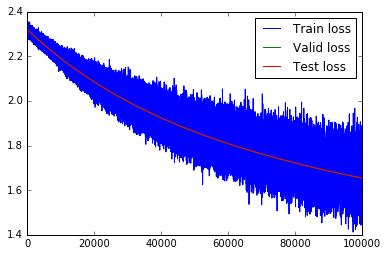

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

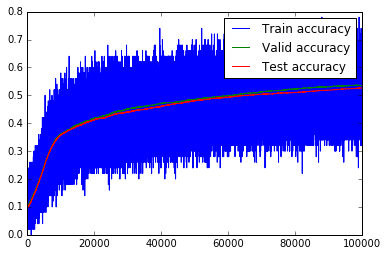

In [6]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()